In [347]:
import os
import pandas as pd
import numpy as np
from scipy.interpolate import Rbf
from scipy.optimize import curve_fit
from datetime import timedelta
from sklearn.metrics import mean_squared_log_error
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import xgboost

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid19-global-forecasting-week-3/submission.csv
/kaggle/input/covid19-global-forecasting-week-3/test.csv
/kaggle/input/covid19-global-forecasting-week-3/train.csv
/kaggle/input/countryinfo/covid19countryinfo.csv
/kaggle/input/countryinfo/covid19tests.csv
/kaggle/input/covid19-global-forecasting-locations-population/locations_population.csv


In [348]:
#load & read the data  
train = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-3/train.csv')
test  = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-3/test.csv')
sub   = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-3/submission.csv')

In [349]:
train.head(10)

Id Province_State Country_Region        Date  ConfirmedCases  Fatalities
0   1            NaN    Afghanistan  2020-01-22             0.0         0.0
1   2            NaN    Afghanistan  2020-01-23             0.0         0.0
2   3            NaN    Afghanistan  2020-01-24             0.0         0.0
3   4            NaN    Afghanistan  2020-01-25             0.0         0.0
4   5            NaN    Afghanistan  2020-01-26             0.0         0.0
5   6            NaN    Afghanistan  2020-01-27             0.0         0.0
6   7            NaN    Afghanistan  2020-01-28             0.0         0.0
7   8            NaN    Afghanistan  2020-01-29             0.0         0.0
8   9            NaN    Afghanistan  2020-01-30             0.0         0.0
9  10            NaN    Afghanistan  2020-01-31             0.0         0.0

In [350]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23562 entries, 0 to 23561
Data columns (total 6 columns):
Id                23562 non-null int64
Province_State    10010 non-null object
Country_Region    23562 non-null object
Date              23562 non-null object
ConfirmedCases    23562 non-null float64
Fatalities        23562 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.1+ MB


In [351]:
test.head(10)

ForecastId Province_State Country_Region        Date
0           1            NaN    Afghanistan  2020-03-26
1           2            NaN    Afghanistan  2020-03-27
2           3            NaN    Afghanistan  2020-03-28
3           4            NaN    Afghanistan  2020-03-29
4           5            NaN    Afghanistan  2020-03-30
5           6            NaN    Afghanistan  2020-03-31
6           7            NaN    Afghanistan  2020-04-01
7           8            NaN    Afghanistan  2020-04-02
8           9            NaN    Afghanistan  2020-04-03
9          10            NaN    Afghanistan  2020-04-04

In [352]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13158 entries, 0 to 13157
Data columns (total 4 columns):
ForecastId        13158 non-null int64
Province_State    5590 non-null object
Country_Region    13158 non-null object
Date              13158 non-null object
dtypes: int64(1), object(3)
memory usage: 411.3+ KB


In [353]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date']  = pd.to_datetime(train['Date'])
train['Province_State'].fillna(' ',inplace=True)
test['Province_State'].fillna(' ',inplace=True)

In [354]:
train.head(10)

Id Province_State Country_Region       Date  ConfirmedCases  Fatalities
0   1                   Afghanistan 2020-01-22             0.0         0.0
1   2                   Afghanistan 2020-01-23             0.0         0.0
2   3                   Afghanistan 2020-01-24             0.0         0.0
3   4                   Afghanistan 2020-01-25             0.0         0.0
4   5                   Afghanistan 2020-01-26             0.0         0.0
5   6                   Afghanistan 2020-01-27             0.0         0.0
6   7                   Afghanistan 2020-01-28             0.0         0.0
7   8                   Afghanistan 2020-01-29             0.0         0.0
8   9                   Afghanistan 2020-01-30             0.0         0.0
9  10                   Afghanistan 2020-01-31             0.0         0.0

In [355]:
test.head(10)

ForecastId Province_State Country_Region       Date
0           1                   Afghanistan 2020-01-22
1           2                   Afghanistan 2020-01-23
2           3                   Afghanistan 2020-01-24
3           4                   Afghanistan 2020-01-25
4           5                   Afghanistan 2020-01-26
5           6                   Afghanistan 2020-01-27
6           7                   Afghanistan 2020-01-28
7           8                   Afghanistan 2020-01-29
8           9                   Afghanistan 2020-01-30
9          10                   Afghanistan 2020-01-31

In [356]:
sub.head(10)

ForecastId  ConfirmedCases  Fatalities
0           1               1           1
1           2               1           1
2           3               1           1
3           4               1           1
4           5               1           1
5           6               1           1
6           7               1           1
7           8               1           1
8           9               1           1
9          10               1           1

In [357]:
print("Number of Country_Region: ", train['Country_Region'].nunique())


Number of Country_Region:  180


In [358]:
print("Dates go from day", max(train['Date']), "to day", min(train['Date']), ", a total of", train['Date'].nunique(), "days")


Dates go from day 2020-04-07 00:00:00 to day 2020-01-22 00:00:00 , a total of 77 days


In [359]:
print("Countries with Province/State informed: ", train.loc[train['Province_State']!='None']['Country_Region'].unique())

Countries with Province/State informed:  ['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burma' 'Burundi'
 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada' 'Central African Republic'
 'Chad' 'Chile' 'China' 'Colombia' 'Congo (Brazzaville)'
 'Congo (Kinshasa)' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba' 'Cyprus'
 'Czechia' 'Denmark' 'Diamond Princess' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Fiji' 'Finland' 'France'
 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece' 'Grenada'
 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti' 'Holy See'
 'Honduras' 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq'
 'Ireland' 'Israel

Text(0.5, 0, 'Date')

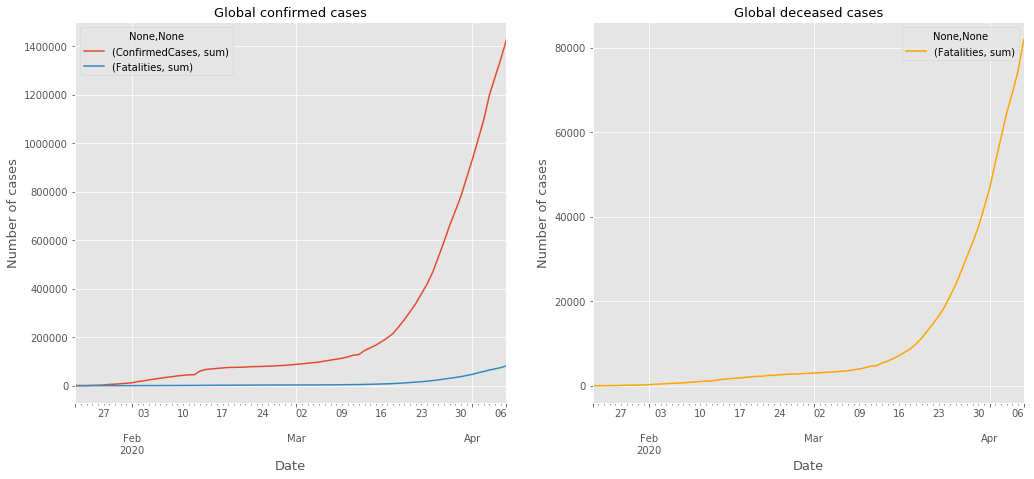

In [360]:
confirmed_total_date = train.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date = train.groupby(['Date']).agg({'Fatalities':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

we calculate new peoples with covid-19 confirmed and fatalities in absolute values and percentages

In [361]:
by_ctry_prov = train.groupby(['Country_Region','Province_State'])[['ConfirmedCases','Fatalities']]
train[['NewCases','NewFatalities']]= by_ctry_prov.transform(lambda x: x.diff().fillna(0))
train[['NewCasesPct','NewFatalitiesPct']]= by_ctry_prov.transform(lambda x: x.pct_change().fillna(0))

In [362]:
train.sort_values('NewCases',ascending = False).head(10)

Id Province_State Country_Region       Date  ConfirmedCases  \
9467   13128                        France 2020-04-04         89953.0   
5181    7192          Hubei          China 2020-02-13         48206.0   
9470   13131                        France 2020-04-07        109069.0   
20478  28429       New York             US 2020-04-04        113833.0   
20477  28428       New York             US 2020-04-03        102987.0   
16772  23283                         Spain 2020-03-25         49515.0   
20479  28430       New York             US 2020-04-05        123160.0   
20474  28425       New York             US 2020-03-31         75833.0   
20480  28431       New York             US 2020-04-06        131815.0   
20476  28427       New York             US 2020-04-02         92506.0   

       Fatalities  NewCases  NewFatalities  NewCasesPct  NewFatalitiesPct  
9467       7560.0   25615.0         1053.0     0.398132          0.161826  
5181       1310.0   14840.0          242.0     0.444764          0.226592  
9470      10328.0   11059.0         1417.0     0.112835          0.159017  
20478      3565.0   10846.0          630.0     0.105314          0.214651  
20477      2935.0   10481.0          562.0     0.113301          0.236831  
16772      3647.0    9630.0          839.0     0.241444          0.298789  
20479      4159.0    9327.0          594.0     0.081936          0.166620  
20474      1550.0    9170.0          332.0     0.137558          0.272578  
20480      4698.0    8655.0          539.0     0.070274          0.129598  
20476      2373.0    8558.0          432.0     0.101944          0.222566

check now for inconsistencies in daily new cases, cumulative count should only increase or remain equal


In [363]:
train[train.NewCases < 0].sort_values('NewCases')

Id            Province_State  Country_Region       Date  \
21323  29604                 Tennessee              US 2020-04-02   
18541  25742      District of Columbia              US 2020-03-23   
21770  30231                Washington              US 2020-03-18   
20245  28106             New Hampshire              US 2020-04-02   
10303  14294                                    Guyana 2020-03-24   
3617    4998                   Ontario          Canada 2020-04-06   
21618  30019            Virgin Islands              US 2020-03-20   
21464  29805                      Utah              US 2020-03-20   
9287   12888          Saint Barthelemy          France 2020-03-09   
20153  27984                    Nevada              US 2020-03-18   
814     1115        Northern Territory       Australia 2020-03-06   
9159   12700             New Caledonia          France 2020-04-04   
4753    6584                   Guizhou           China 2020-03-18   
3066    4237                   Alberta          Canada 2020-03-25   
858     1189                Queensland       Australia 2020-02-02   
856     1187                Queensland       Australia 2020-01-31   
17993  24984                    Alaska              US 2020-03-14   
22940  31851  Turks and Caicos Islands  United Kingdom 2020-04-02   

       ConfirmedCases  Fatalities  NewCases  NewFatalities  NewCasesPct  \
21323          2845.0        36.0     -88.0           12.0    -0.030003   
18541           120.0         2.0     -84.0            0.0    -0.411765   
21770          1014.0        55.0     -62.0            0.0    -0.057621   
20245           316.0         3.0     -51.0            0.0    -0.138965   
10303             5.0         1.0     -15.0            0.0    -0.750000   
3617           4347.0       150.0      -7.0           31.0    -0.001608   
21618             0.0         0.0      -3.0            0.0    -1.000000   
21464            78.0         0.0      -2.0            0.0    -0.025000   
9287              1.0         0.0      -2.0            0.0    -0.666667   
20153            55.0         1.0      -1.0            0.0    -0.017857   
814               0.0         0.0      -1.0            0.0    -1.000000   
9159             17.0         0.0      -1.0            0.0    -0.055556   
4753            146.0         2.0      -1.0            0.0    -0.006803   
3066            358.0         2.0      -1.0            1.0    -0.002786   
858               2.0         0.0      -1.0            0.0    -0.333333   
856               2.0         0.0      -1.0            0.0    -0.333333   
17993             0.0         0.0      -1.0            0.0    -1.000000   
22940             5.0         0.0      -1.0            0.0    -0.166667   

       NewFatalitiesPct  
21323          0.500000  
18541          0.000000  
21770          0.000000  
20245          0.000000  
10303          0.000000  
3617           0.260504  
21618          0.000000  
21464          0.000000  
9287           0.000000  
20153          0.000000  
814            0.000000  
9159           0.000000  
4753           0.000000  
3066           1.000000  
858            0.000000  
856            0.000000  
17993          0.000000  
22940          0.000000

In [364]:
train[train.NewFatalities < 0].sort_values('NewFatalities')

Id        Province_State Country_Region       Date  ConfirmedCases  \
10680  14821                              Iceland 2020-03-16           180.0   
21705  30136              Virginia             US 2020-03-30          1020.0   
11532  16003                           Kazakhstan 2020-03-21            53.0   
16157  22428                               Serbia 2020-03-26           384.0   
7312   10133                               Cyprus 2020-04-05           446.0   
15149  21030                          Philippines 2020-03-19           217.0   
18556  25757  District of Columbia             US 2020-04-07          1211.0   
3756    5197                Quebec         Canada 2020-03-22           219.0   
8699   12060                              Finland 2020-04-06          2176.0   
10684  14825                              Iceland 2020-03-20           409.0   
10762  14933                                India 2020-03-21           330.0   
11546  16017                           Kazakhstan 2020-04-04           531.0   
16461  22852                             Slovakia 2020-03-22           185.0   
18851  26172                Hawaii             US 2020-03-25            91.0   
20015  27786               Montana             US 2020-04-03           243.0   

       Fatalities  NewCases  NewFatalities  NewCasesPct  NewFatalitiesPct  
10680         0.0       9.0           -5.0     0.052632         -1.000000  
21705        15.0     130.0           -5.0     0.146067         -0.250000  
11532         0.0       4.0           -3.0     0.081633         -1.000000  
16157         1.0       0.0           -3.0     0.000000         -0.750000  
7312          9.0      20.0           -2.0     0.046948         -0.181818  
15149        17.0      15.0           -2.0     0.074257         -0.105263  
18556        22.0     114.0           -2.0     0.103920         -0.083333  
3756          4.0      38.0           -1.0     0.209945         -0.200000  
8699         27.0     249.0           -1.0     0.129216         -0.035714  
10684         0.0      79.0           -1.0     0.239394         -1.000000  
10762         4.0      86.0           -1.0     0.352459         -0.200000  
11546         5.0      67.0           -1.0     0.144397         -0.166667  
16461         0.0       7.0           -1.0     0.039326         -1.000000  
18851         0.0       1.0           -1.0     0.011111         -1.000000  
20015         5.0       2.0           -1.0     0.008299         -0.166667

In [365]:
train[train.Fatalities > train.ConfirmedCases]

Empty DataFrame
Columns: [Id, Province_State, Country_Region, Date, ConfirmedCases, Fatalities, NewCases, NewFatalities, NewCasesPct, NewFatalitiesPct]
Index: []

In [366]:
#more than 40% increase in ConfirmedCases with at least 1000 new cases
train[(train.NewCasesPct > 0.4) & (train.NewCases > 1000)]

Id Province_State  Country_Region       Date  ConfirmedCases  \
5165    7176          Hubei           China 2020-01-28          3554.0   
5170    7181          Hubei           China 2020-02-02         11177.0   
5181    7192          Hubei           China 2020-02-13         48206.0   
9445   13106                         France 2020-03-13          3661.0   
9448   13109                         France 2020-03-16          6633.0   
9753   13534                        Germany 2020-03-13          3675.0   
11151  15472                         Israel 2020-03-25          2369.0   
11216  15567                          Italy 2020-03-13         17660.0   
16760  23271                          Spain 2020-03-13          5232.0   
17851  24782                         Turkey 2020-03-26          3629.0   
17852  24783                         Turkey 2020-03-27          5698.0   
19398  26929      Louisiana              US 2020-04-02          9159.0   
20315  28206     New Jersey              US 2020-03-26          6876.0   
20462  28413       New York              US 2020-03-19          5365.0   
20463  28414       New York              US 2020-03-20          8310.0   
20464  28415       New York              US 2020-03-21         11710.0   
23004  31945                 United Kingdom 2020-03-20          3983.0   

       Fatalities  NewCases  NewFatalities  NewCasesPct  NewFatalitiesPct  
5165        125.0    2131.0           49.0     1.497540          0.644737  
5170        350.0    4024.0          101.0     0.562561          0.405622  
5181       1310.0   14840.0          242.0     0.444764          0.226592  
9445         79.0    1380.0           31.0     0.604998          0.645833  
9448        148.0    2134.0           57.0     0.474328          0.626374  
9753          7.0    1597.0            4.0     0.768527          1.333333  
11151         5.0    1131.0            2.0     0.913570          0.666667  
11216      1266.0    5198.0          439.0     0.417108          0.530834  
16760       133.0    2955.0           78.0     1.297760          1.418182  
17851        75.0    1196.0           16.0     0.491574          0.271186  
17852        92.0    2069.0           17.0     0.570130          0.226667  
19398       310.0    2735.0           37.0     0.425747          0.135531  
20315        81.0    2474.0           19.0     0.562017          0.306452  
20462        34.0    2870.0           18.0     1.150301          1.125000  
20463        42.0    2945.0            8.0     0.548928          0.235294  
20464        60.0    3400.0           18.0     0.409146          0.428571  
23004       177.0    1294.0           40.0     0.481220          0.291971

In [367]:
#more than 80% increase in Fatalities with at least 50 new cases
train[(train.NewFatalitiesPct > 0.8) & (train.NewFatalities > 50)]

Id Province_State  Country_Region       Date  ConfirmedCases  \
9452   13113                         France 2020-03-20         12612.0   
16760  23271                          Spain 2020-03-13          5232.0   
18628  25859        Florida              US 2020-04-02          9008.0   
20465  28416       New York              US 2020-03-22         15800.0   
23003  31944                 United Kingdom 2020-03-19          2689.0   

       Fatalities  NewCases  NewFatalities  NewCasesPct  NewFatalitiesPct  
9452        450.0    1741.0          207.0     0.160151          0.851852  
16760       133.0    2955.0           78.0     1.297760          1.418182  
18628       164.0    2052.0           77.0     0.294997          0.885057  
20465       117.0    4090.0           57.0     0.349274          0.950000  
23003       137.0      63.0           66.0     0.023991          0.929577

In [368]:
def lin_interpolate(indx1,indx2,col,df):
    start_val = df.loc[indx1,col]
    end_val = df.loc[indx2,col]
    i = indx1+1
    while i < indx2:
        df.loc[i,col] = start_val + int((i-indx1)/(indx2-indx1)*(end_val-start_val))
        i+=1

In [369]:
#Shandong 21 Feb
train[(train['Country_Region']=='China') & 
         (train['Province_State']=='Shandong') &
         (train.Date > '2020-02-18')].head(5)

Id Province_State Country_Region       Date  ConfirmedCases  \
6034  8375       Shandong          China 2020-02-19           544.0   
6035  8376       Shandong          China 2020-02-20           546.0   
6036  8377       Shandong          China 2020-02-21           749.0   
6037  8378       Shandong          China 2020-02-22           750.0   
6038  8379       Shandong          China 2020-02-23           754.0   

      Fatalities  NewCases  NewFatalities  NewCasesPct  NewFatalitiesPct  
6034         3.0       1.0            0.0     0.001842          0.000000  
6035         4.0       2.0            1.0     0.003676          0.333333  
6036         4.0     203.0            0.0     0.371795          0.000000  
6037         4.0       1.0            0.0     0.001335          0.000000  
6038         4.0       4.0            0.0     0.005333          0.000000

In [370]:
#Hubei 13 Feb
train[(train['Country_Region']=='China') & 
         (train['Province_State']=='Hubei') &
         (train.Date > '2020-02-8')].head(10)

Id Province_State Country_Region       Date  ConfirmedCases  \
5177  7188          Hubei          China 2020-02-09         29631.0   
5178  7189          Hubei          China 2020-02-10         31728.0   
5179  7190          Hubei          China 2020-02-11         33366.0   
5180  7191          Hubei          China 2020-02-12         33366.0   
5181  7192          Hubei          China 2020-02-13         48206.0   
5182  7193          Hubei          China 2020-02-14         54406.0   
5183  7194          Hubei          China 2020-02-15         56249.0   
5184  7195          Hubei          China 2020-02-16         58182.0   
5185  7196          Hubei          China 2020-02-17         59989.0   
5186  7197          Hubei          China 2020-02-18         61682.0   

      Fatalities  NewCases  NewFatalities  NewCasesPct  NewFatalitiesPct  
5177       871.0    2531.0           91.0     0.093395          0.116667  
5178       974.0    2097.0          103.0     0.070770          0.118255  
5179      1068.0    1638.0           94.0     0.051626          0.096509  
5180      1068.0       0.0            0.0     0.000000          0.000000  
5181      1310.0   14840.0          242.0     0.444764          0.226592  
5182      1457.0    6200.0          147.0     0.128615          0.112214  
5183      1596.0    1843.0          139.0     0.033875          0.095402  
5184      1696.0    1933.0          100.0     0.034365          0.062657  
5185      1789.0    1807.0           93.0     0.031058          0.054835  
5186      1921.0    1693.0          132.0     0.028222          0.073784

In [371]:
#fix China Hubei 12-14 Feb reporting and Shandong 21 Feb
#need to check indexes don't change every new training set
#decided to fix on new cases only
lin_interpolate(5044,5049,'NewCases',train) #Hubei 12-14 Feb
lin_interpolate(5879,5881,'NewCases',train) #Shandong 21 Feb

In [372]:
all_ctry_lst = list(train.set_index(['Country_Region','Province_State']).index.unique())
len(all_ctry_lst)

306

In [373]:
train['Country_Region'].nunique()

180

In [374]:
c = train[train['Province_State'] != 'UniqueProvince'].groupby('Country_Region')['Province_State'].unique()
[(x,list(c.loc[x])) for x in c.index]

[('Afghanistan', [' ']),
 ('Albania', [' ']),
 ('Algeria', [' ']),
 ('Andorra', [' ']),
 ('Angola', [' ']),
 ('Antigua and Barbuda', [' ']),
 ('Argentina', [' ']),
 ('Armenia', [' ']),
 ('Australia',
  ['Australian Capital Territory',
   'New South Wales',
   'Northern Territory',
   'Queensland',
   'South Australia',
   'Tasmania',
   'Victoria',
   'Western Australia']),
 ('Austria', [' ']),
 ('Azerbaijan', [' ']),
 ('Bahamas', [' ']),
 ('Bahrain', [' ']),
 ('Bangladesh', [' ']),
 ('Barbados', [' ']),
 ('Belarus', [' ']),
 ('Belgium', [' ']),
 ('Belize', [' ']),
 ('Benin', [' ']),
 ('Bhutan', [' ']),
 ('Bolivia', [' ']),
 ('Bosnia and Herzegovina', [' ']),
 ('Botswana', [' ']),
 ('Brazil', [' ']),
 ('Brunei', [' ']),
 ('Bulgaria', [' ']),
 ('Burkina Faso', [' ']),
 ('Burma', [' ']),
 ('Burundi', [' ']),
 ('Cabo Verde', [' ']),
 ('Cambodia', [' ']),
 ('Cameroon', [' ']),
 ('Canada',
  ['Alberta',
   'British Columbia',
   'Manitoba',
   'New Brunswick',
   'Newfoundland and Labrador'

In [375]:
train[train['Country_Region']=='China']['Province_State'].unique()

array(['Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong',
       'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan',
       'Hong Kong', 'Hubei', 'Hunan', 'Inner Mongolia', 'Jiangsu',
       'Jiangxi', 'Jilin', 'Liaoning', 'Macau', 'Ningxia', 'Qinghai',
       'Shaanxi', 'Shandong', 'Shanghai', 'Shanxi', 'Sichuan', 'Tianjin',
       'Tibet', 'Xinjiang', 'Yunnan', 'Zhejiang'], dtype=object)

In [376]:
EVAL_DATE = pd.to_datetime('3/23/2020')
EVAL_MODE = True
if EVAL_MODE:
    TRAIN_LAST_DATE = EVAL_DATE
else:
    TRAIN_LAST_DATE = train.Date.max()
PRED_LAST_DATE  = test.Date.max()

In [377]:
train.drop(['Id','NewCasesPct','NewFatalitiesPct'],axis=1,inplace=True)

In [378]:
# evaluation data 
df_eval  = train[train['Date'] >  EVAL_DATE]
train = train[train['Date'] <= TRAIN_LAST_DATE]

In [379]:
#add ForecastId column
df_eval = df_eval.merge(test,on=['Date', 'Country_Region', 'Province_State'],how='left',validate='1:1')
df_eval

Province_State Country_Region       Date  ConfirmedCases  Fatalities  \
0                      Afghanistan 2020-03-24            74.0         1.0   
1                      Afghanistan 2020-03-25            84.0         2.0   
2                      Afghanistan 2020-03-26            94.0         4.0   
3                      Afghanistan 2020-03-27           110.0         4.0   
4                      Afghanistan 2020-03-28           110.0         4.0   
...             ...            ...        ...             ...         ...   
4585                      Zimbabwe 2020-04-03             9.0         1.0   
4586                      Zimbabwe 2020-04-04             9.0         1.0   
4587                      Zimbabwe 2020-04-05             9.0         1.0   
4588                      Zimbabwe 2020-04-06            10.0         1.0   
4589                      Zimbabwe 2020-04-07            11.0         2.0   

      NewCases  NewFatalities  ForecastId  
0         34.0            0.0         NaN  
1         10.0            1.0         NaN  
2         10.0            2.0         NaN  
3         16.0            0.0         NaN  
4          0.0            0.0         NaN  
...        ...            ...         ...  
4585       0.0            0.0         NaN  
4586       0.0            0.0         NaN  
4587       0.0            0.0         NaN  
4588       1.0            0.0         NaN  
4589       1.0            1.0         NaN  

[4590 rows x 8 columns]

In [380]:
df_corona = train[['Province_State','Country_Region','Date','ConfirmedCases','Fatalities','NewCases']].copy()

In [381]:
#population per province dataset 
df_pop = pd.read_csv('/kaggle/input/covid19-global-forecasting-locations-population/locations_population.csv')

In [382]:
df_pop.head(10)

Province.State       Country.Region  Population Provenance
0                           NaN          Afghanistan    35530000        NaN
1                           NaN              Albania     2877000        NaN
2                           NaN              Algeria    41320000        NaN
3                           NaN              Andorra       78000        NaN
4                           NaN  Antigua and Barbuda      102012        NaN
5                           NaN            Argentina    44270000        NaN
6                           NaN              Armenia     2973000        NaN
7                           NaN               Angola    29780000        NaN
8                           NaN                Aruba      105264        NaN
9  Australian Capital Territory            Australia      426709        NaN

In [383]:
df_pop['Province.State'].fillna(' ',inplace=True)
df_pop.drop(labels=['Provenance'],axis=1,inplace=True)
df_pop

Province.State       Country.Region  Population
0                           Afghanistan    35530000
1                               Albania     2877000
2                               Algeria    41320000
3                               Andorra       78000
4                   Antigua and Barbuda      102012
..             ...                  ...         ...
328                           Venezuela    31980000
329                             Vietnam    95540000
330                  West Bank and Gaza     4776131
331                              Zambia    17090000
332                            Zimbabwe    16530000

[333 rows x 3 columns]

In [384]:
#manually fix for locations_population.csv file
df_pop = df_pop.append({'Province.State':' ','Country.Region':'Botswana','Population':2254068},ignore_index=True)
df_pop = df_pop.append({'Province.State':' ','Country.Region':'Burma','Population':53582855 },ignore_index=True)
df_pop = df_pop.append({'Province.State':' ','Country.Region':'Burundi','Population':11745876 },ignore_index=True)
df_pop = df_pop.append({'Province.State':' ','Country.Region':'Sierra Leone','Population':7092113 },ignore_index=True)
df_pop = df_pop.append({'Province.State':' ','Country.Region':'West Bank and Gaza','Population':4550000 },ignore_index=True)
df_pop = df_pop.append({'Province.State':' ','Country.Region':'MS Zaandam','Population':1800 },ignore_index=True)

In [385]:
df_pop

Province.State       Country.Region  Population
0                           Afghanistan    35530000
1                               Albania     2877000
2                               Algeria    41320000
3                               Andorra       78000
4                   Antigua and Barbuda      102012
..             ...                  ...         ...
334                               Burma    53582855
335                             Burundi    11745876
336                        Sierra Leone     7092113
337                  West Bank and Gaza     4550000
338                          MS Zaandam        1800

[339 rows x 3 columns]

In [386]:
a = set(df_corona['Country_Region'])
a

{'Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burma',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 

In [387]:
b = set(df_pop['Country.Region'])
b

{'Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burma',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cruise Ship',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'French Guiana',
 'Gabon',
 'Gambia',
 'Gambia, The',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Greenland',
 'G

In [388]:
df_corona = df_corona.merge(df_pop,"left",left_on=['Country_Region','Province_State'],
                            right_on=['Country.Region','Province.State'],indicator=True,
                            #validate='many_to_one'
                           )

In [389]:
df_corona

Province_State Country_Region       Date  ConfirmedCases  Fatalities  \
0                       Afghanistan 2020-01-22             0.0         0.0   
1                       Afghanistan 2020-01-23             0.0         0.0   
2                       Afghanistan 2020-01-24             0.0         0.0   
3                       Afghanistan 2020-01-25             0.0         0.0   
4                       Afghanistan 2020-01-26             0.0         0.0   
...              ...            ...        ...             ...         ...   
19339                      Zimbabwe 2020-03-19             0.0         0.0   
19340                      Zimbabwe 2020-03-20             1.0         0.0   
19341                      Zimbabwe 2020-03-21             3.0         0.0   
19342                      Zimbabwe 2020-03-22             3.0         0.0   
19343                      Zimbabwe 2020-03-23             3.0         1.0   

       NewCases Province.State Country.Region  Population _merge  
0           0.0                   Afghanistan    35530000   both  
1           0.0                   Afghanistan    35530000   both  
2           0.0                   Afghanistan    35530000   both  
3           0.0                   Afghanistan    35530000   both  
4           0.0                   Afghanistan    35530000   both  
...         ...            ...            ...         ...    ...  
19339       0.0                      Zimbabwe    16530000   both  
19340       1.0                      Zimbabwe    16530000   both  
19341       2.0                      Zimbabwe    16530000   both  
19342       0.0                      Zimbabwe    16530000   both  
19343       0.0                      Zimbabwe    16530000   both  

[19344 rows x 10 columns]

In [390]:
df_corona._merge.value_counts()

both          19344
right_only        0
left_only         0
Name: _merge, dtype: int64

In [391]:
df_corona['new_cases_per_pop']=df_corona['NewCases']/df_corona['Population']*100000
df_corona.drop(['_merge'],axis=1,inplace=True)
df_corona

Province_State Country_Region       Date  ConfirmedCases  Fatalities  \
0                       Afghanistan 2020-01-22             0.0         0.0   
1                       Afghanistan 2020-01-23             0.0         0.0   
2                       Afghanistan 2020-01-24             0.0         0.0   
3                       Afghanistan 2020-01-25             0.0         0.0   
4                       Afghanistan 2020-01-26             0.0         0.0   
...              ...            ...        ...             ...         ...   
19339                      Zimbabwe 2020-03-19             0.0         0.0   
19340                      Zimbabwe 2020-03-20             1.0         0.0   
19341                      Zimbabwe 2020-03-21             3.0         0.0   
19342                      Zimbabwe 2020-03-22             3.0         0.0   
19343                      Zimbabwe 2020-03-23             3.0         1.0   

       NewCases Province.State Country.Region  Population  new_cases_per_pop  
0           0.0                   Afghanistan    35530000           0.000000  
1           0.0                   Afghanistan    35530000           0.000000  
2           0.0                   Afghanistan    35530000           0.000000  
3           0.0                   Afghanistan    35530000           0.000000  
4           0.0                   Afghanistan    35530000           0.000000  
...         ...            ...            ...         ...                ...  
19339       0.0                      Zimbabwe    16530000           0.000000  
19340       1.0                      Zimbabwe    16530000           0.006050  
19341       2.0                      Zimbabwe    16530000           0.012099  
19342       0.0                      Zimbabwe    16530000           0.000000  
19343       0.0                      Zimbabwe    16530000           0.000000  

[19344 rows x 10 columns]

In [392]:
#info about total cases per country/province
df_corona.groupby(['Country_Region','Province_State']).ConfirmedCases.max().describe()

count      306.000000
mean      1235.444444
std       6271.978005
min          0.000000
25%         13.000000
50%         98.000000
75%        400.250000
max      67800.000000
Name: ConfirmedCases, dtype: float64

In [393]:
len(df_corona.groupby(['Country_Region','Province_State'])) #number of countries/provinces in dataset

306

In [394]:
df_corona.Country_Region.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guinea', 'Guine

In [395]:
def filter_out(x):
    f1 = x['ConfirmedCases'].max() > 30      #at least 30 sick cases
    f2 = x['Population'].min() > 2000000     #pop more than 2M, small countries with distorted percent of confirmed cases
    f3 = x['new_cases_per_pop'].max() > 0.1  #at least 0.1 cases per 100K pop
    return f1 & f2 & f3

In [396]:
#create reduced filtered dataset for analysis
df_analysis = df_corona.groupby(['Province_State','Country_Region']).filter(filter_out).copy()

print('number of countries in dataset = ', len(df_analysis.groupby(['Country_Region','Province_State']))) 

number of countries in dataset =  129


In [397]:
df_analysis['Country_Region'].unique()

array(['Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Belarus', 'Belgium',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burkina Faso',
       'Cambodia', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica',
       'Croatia', 'Cuba', 'Czechia', 'Denmark', 'Dominican Republic',
       'Ecuador', 'Finland', 'France', 'Georgia', 'Germany', 'Greece',
       'Hungary', 'Iran', 'Ireland', 'Israel', 'Italy', 'Jordan',
       'Kazakhstan', 'Korea, South', 'Kuwait', 'Lebanon', 'Lithuania',
       'Malaysia', 'Moldova', 'Netherlands', 'New Zealand',
       'North Macedonia', 'Norway', 'Oman', 'Pakistan', 'Panama', 'Peru',
       'Poland', 'Portugal', 'Qatar', 'Romania', 'Rwanda', 'Saudi Arabia',
       'Senegal', 'Serbia', 'Singapore', 'Slovakia', 'Slovenia',
       'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Taiwan*',
       'Thailand', 'Tunisia', 'Turkey', 'US', 'United Arab Emirates',
       'United Kingdom', 'Uruguay', 'West Bank

In [398]:
#filter out all dates before there are at least 5 new covid cases daily
df_filt = pd.DataFrame(columns=df_analysis.columns)
for grp in df_analysis.groupby(['Province_State','Country_Region']):
    start_indx = grp[1].loc[grp[1].NewCases >= 5,:].index
    if len(start_indx) > 0:
        df_filt = pd.concat([df_filt,grp[1].loc[start_indx[0]:,:]])

In [399]:
#remove countries with less than 5 days of meaningful new daily cases
df_filt = df_filt.groupby(['Province_State','Country_Region']).filter(lambda x: len(x.Date) > 4)

In [400]:
len(df_filt.groupby(['Country_Region','Province_State'])) #final number of countries/provinces after filtering

126

In [401]:
df_filt['Country_Region'].unique()

array(['Albania', 'Algeria', 'Argentina', 'Armenia', 'Austria',
       'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina',
       'Brazil', 'Bulgaria', 'Burkina Faso', 'Cambodia', 'Chile',
       'Colombia', 'Costa Rica', 'Croatia', 'Czechia', 'Denmark',
       'Dominican Republic', 'Ecuador', 'Finland', 'France', 'Georgia',
       'Germany', 'Greece', 'Hungary', 'Iran', 'Ireland', 'Israel',
       'Italy', 'Jordan', 'Kazakhstan', 'Korea, South', 'Kuwait',
       'Lebanon', 'Lithuania', 'Malaysia', 'Moldova', 'Netherlands',
       'New Zealand', 'North Macedonia', 'Norway', 'Oman', 'Pakistan',
       'Panama', 'Peru', 'Poland', 'Portugal', 'Qatar', 'Romania',
       'Saudi Arabia', 'Senegal', 'Serbia', 'Singapore', 'Slovakia',
       'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland',
       'Taiwan*', 'Thailand', 'Tunisia', 'Turkey', 'United Arab Emirates',
       'United Kingdom', 'Uruguay', 'West Bank and Gaza', 'US', 'Canada',
       'China', 'Australia'], dtype

In [402]:
ctry_prov_lst = list(df_filt.set_index(['Country_Region','Province_State']).index.unique())

In [403]:
def country_prov_select(cntry,prov,df):
    df_sel = df[(df['Country_Region'] == cntry) & (df['Province_State'] == prov)].reset_index(drop=True)
    #consistency check, fails for China after fixing 13/2 reports
    #assert(all(df_sel.ConfirmedCases == df_sel.NewCases.cumsum()))
    return df_sel.fillna(0)

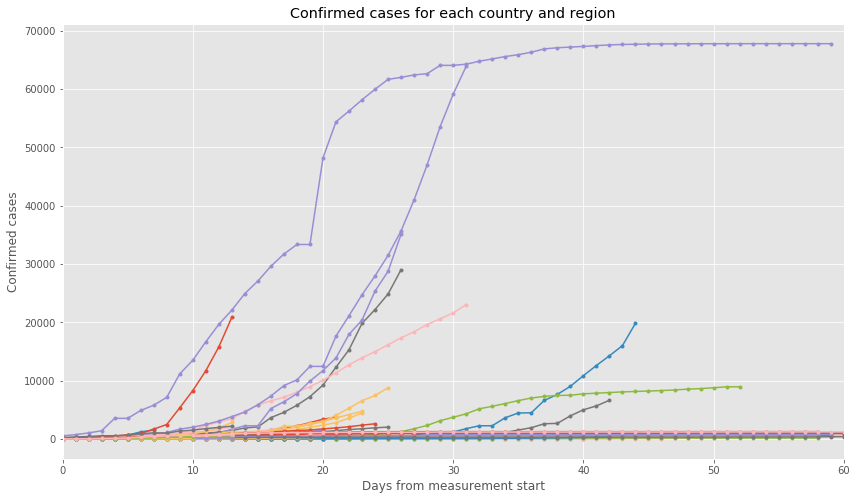

In [404]:
fig, ax = plt.subplots()
df_filt.groupby(['Province_State','Country_Region']).plot(y='ConfirmedCases',
                                                          use_index=False,ax=ax,figsize = (14,8),
                                                          marker='.',
                                                          legend=False,
                                                          title='Confirmed cases for each country and region')
ax.set_xlabel('Days from measurement start')
ax.set_ylabel('Confirmed cases')
plt.show()

In [405]:
#show maximum daily new cases 
df_filt.groupby(['Province_State','Country_Region']).new_cases_per_pop.max().sort_values(ascending=False)[:30]

Province_State    Country_Region
New York          US                26.134033
Hubei             China             25.144019
                  Switzerland       15.414236
                  Spain             13.647664
                  Italy             10.841601
New Jersey        US                10.470391
                  Austria           10.111086
                  Qatar              9.018568
Louisiana         US                 7.206170
                  France             5.972053
                  Ireland            5.486542
                  Norway             5.476900
                  Germany            5.469260
                  Belgium            5.140351
Quebec            Canada             4.790532
Washington        US                 4.753842
                  Portugal           4.470360
Connecticut       US                 3.730415
                  Netherlands        3.707800
Colorado          US                 3.490349
                  Denmark            3.319650
B

In [406]:
df_filt = df_filt.set_index(['Province_State','Country_Region'])
df_filt['max_ratio'] = df_filt.groupby(['Province_State','Country_Region']).new_cases_per_pop.max()
df_filt.reset_index(inplace=True)
df_filt.sort_values(by=['max_ratio'],ascending=False,inplace=True,kind='mergesort') #mergesort is stable

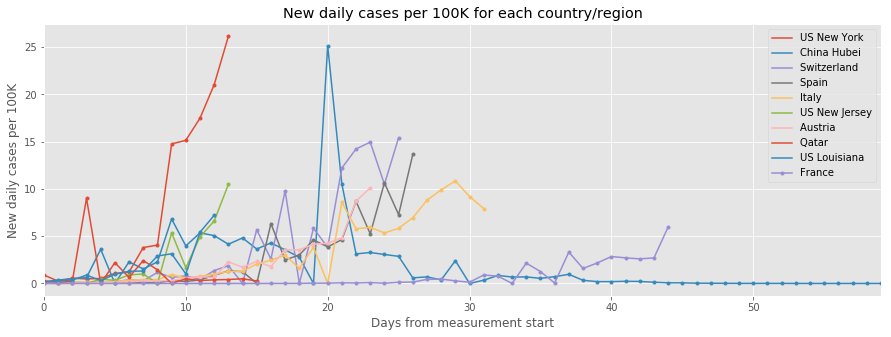

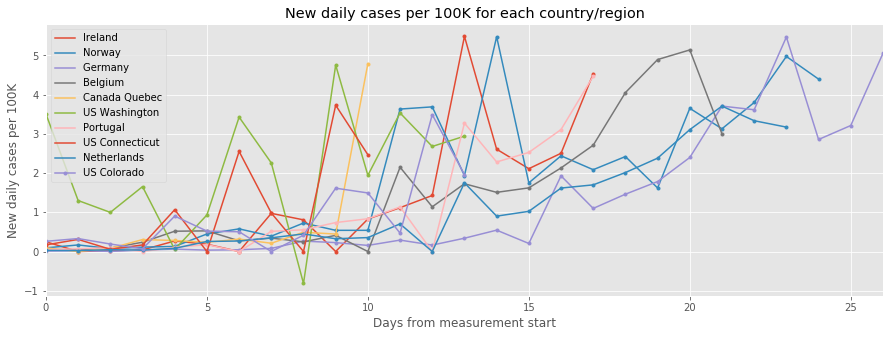

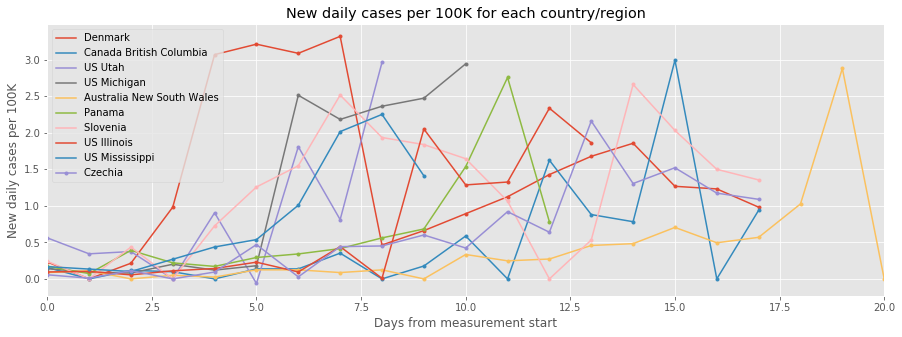

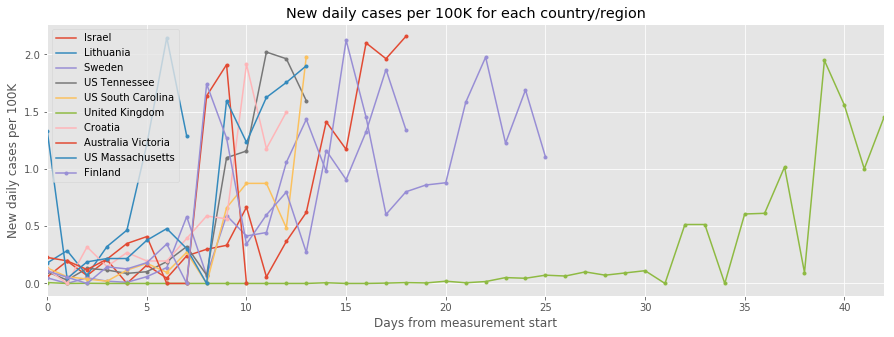

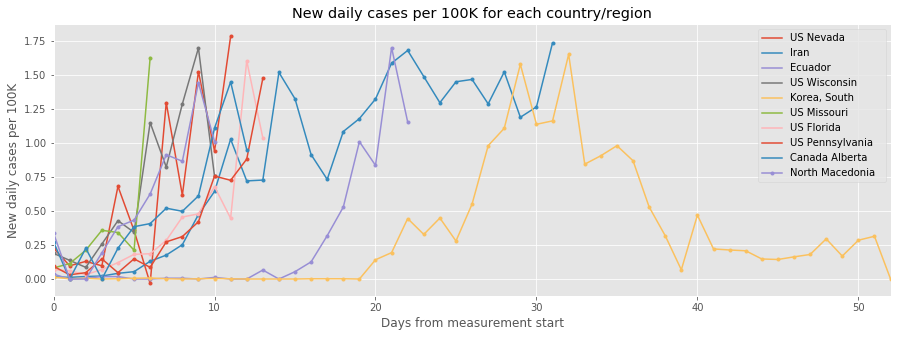

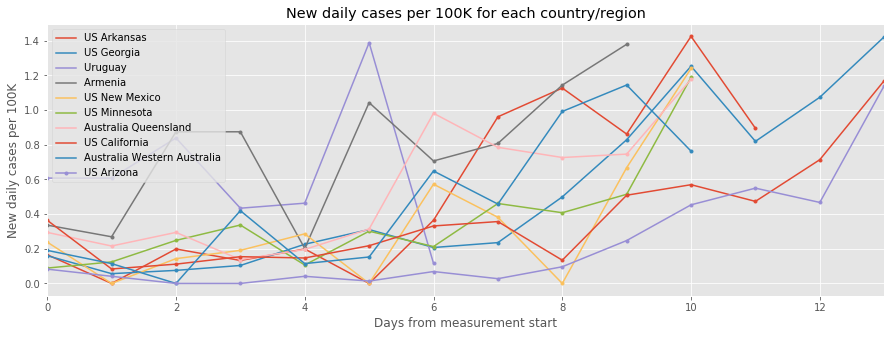

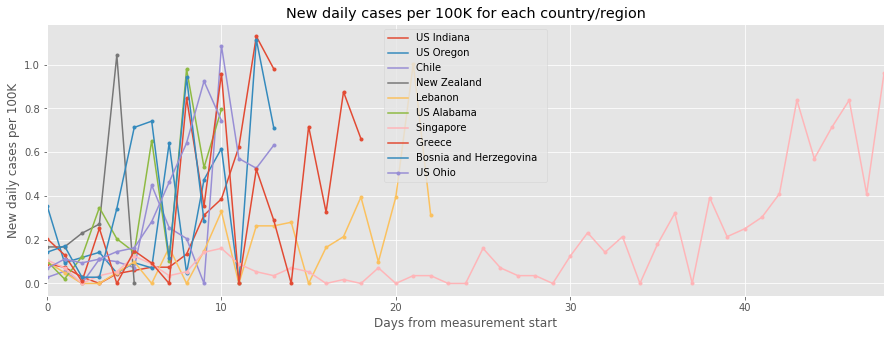

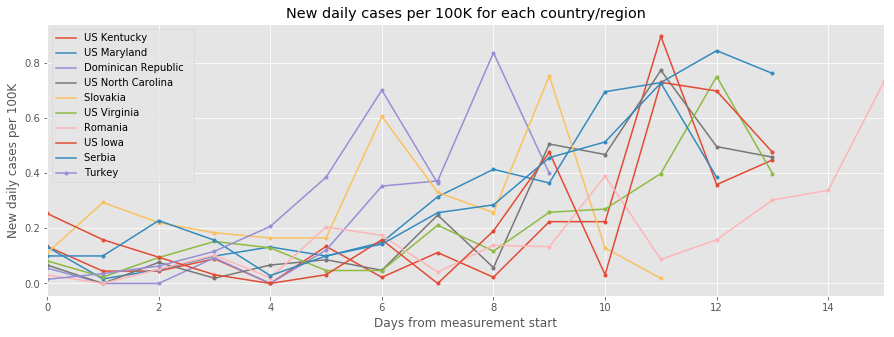

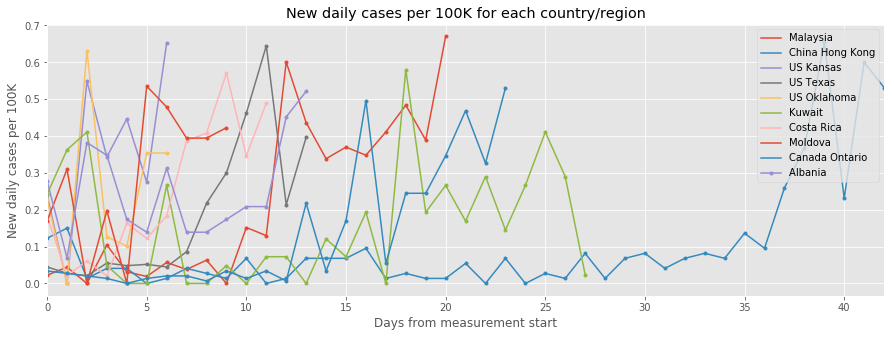

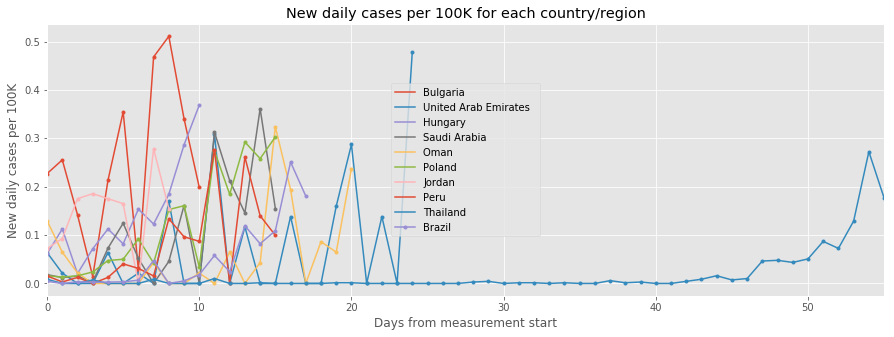

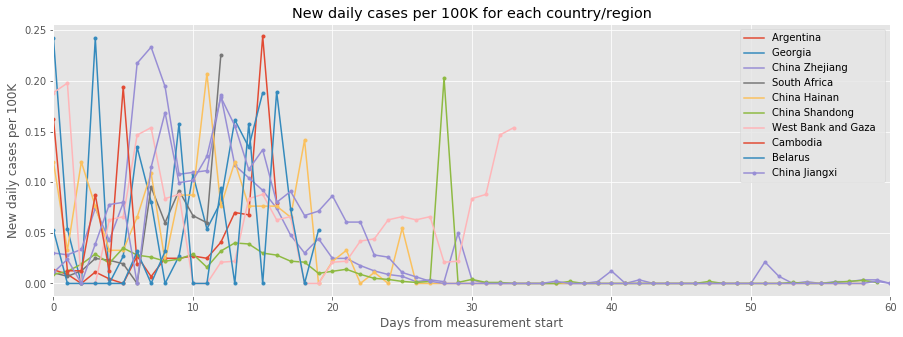

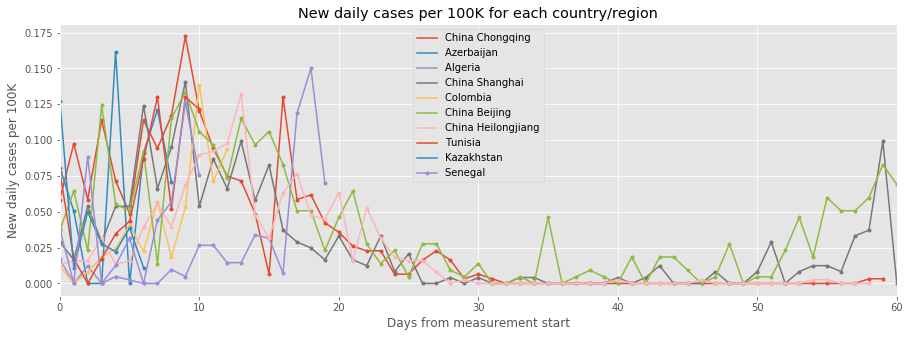

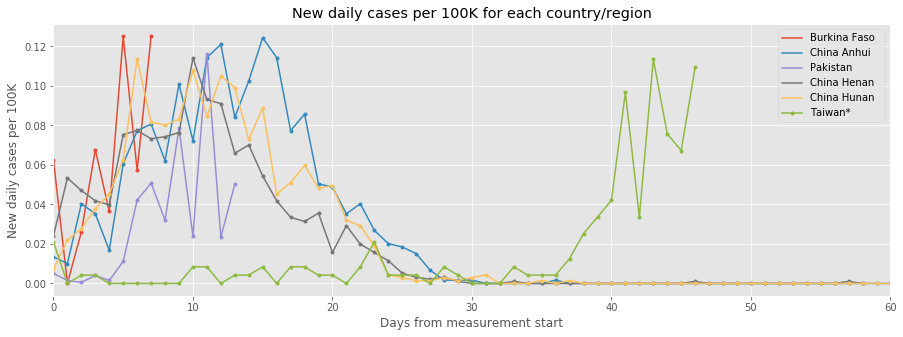

In [407]:
# daily new cases in batches of 10 to be able to see difference, sorted by severity
i = 0
for ctry,grp in df_filt.groupby(['Province_State','Country_Region'],sort=False):
    if i%10==0: #new plot for group
        fig, ax = plt.subplots()
        ax.set_xlabel('Days from measurement start')
        ax.set_ylabel('New daily cases per 100K')
    grp.plot(y='new_cases_per_pop',use_index=False, ax=ax, figsize=(15,5), label=ctry[1]+" "+ctry[0], marker='.',
                                legend=True,title='New daily cases per 100K for each country/region')
    i +=1

plt.show()

In [408]:
#candidate functions definition for curve fitting
def exp_func(x,a,b):
    return a*np.exp(b*x)

def poly_func(x,a,b):
    return a*(x**b)

def sigmoid_func(x,a,b,c):
    return a/(1+np.exp(-b*(x-c)))

* loop over all countries/provinces
* check curve fit for exponential and polynomial function for countries which passed the peak of the infection
* uses new cases per day per 100K of the country population as time series values for radial basis function interpolation
* saves peak duration list for countries that seem to be after infection peak and the curve fitting params

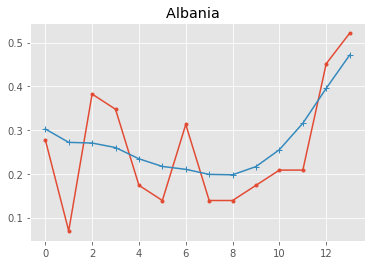

Peak not yet reached for Albania  


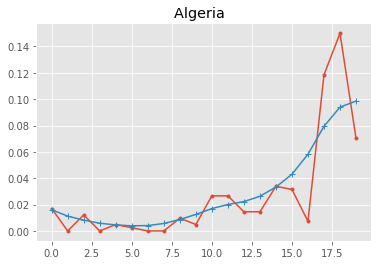

Peak not yet reached for Algeria  


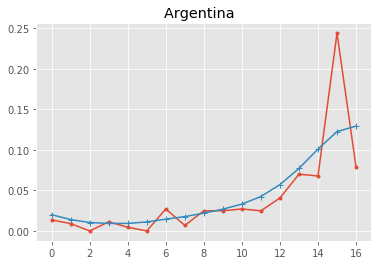

Peak not yet reached for Argentina  


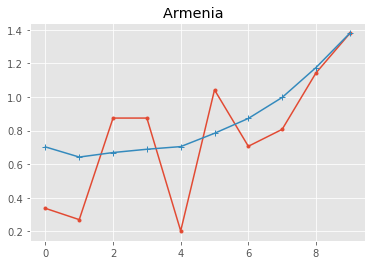

Peak not yet reached for Armenia  


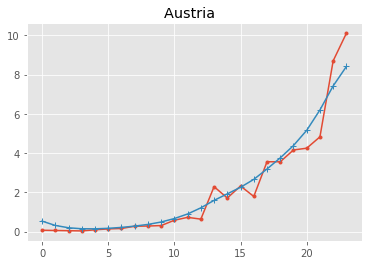

Peak not yet reached for Austria  


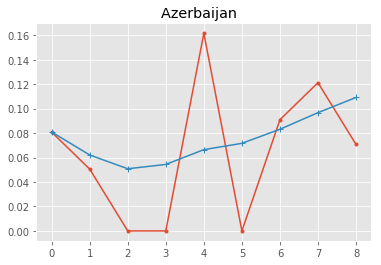

Peak not yet reached for Azerbaijan  


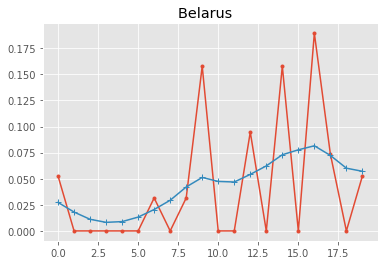

Peak not yet reached for Belarus  


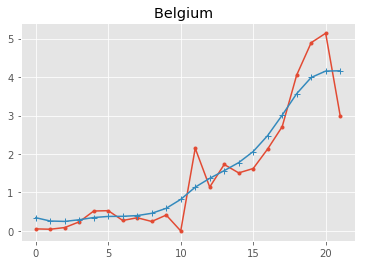

Peak not yet reached for Belgium  


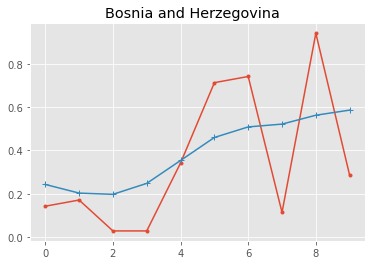

Peak not yet reached for Bosnia and Herzegovina  


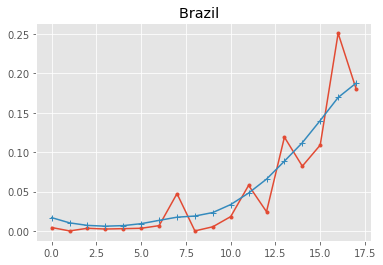

Peak not yet reached for Brazil  


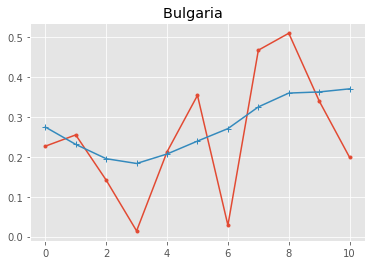

Peak not yet reached for Bulgaria  


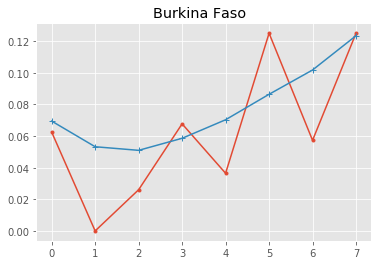

Peak not yet reached for Burkina Faso  


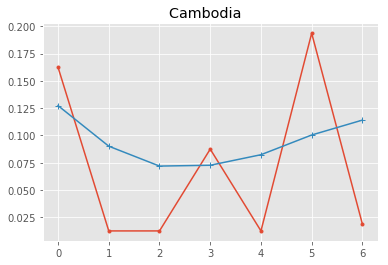

Peak not yet reached for Cambodia  


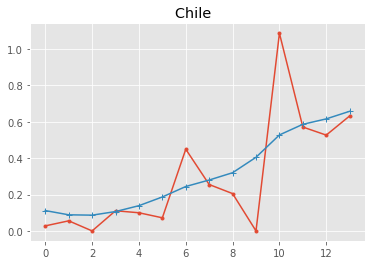

Peak not yet reached for Chile  


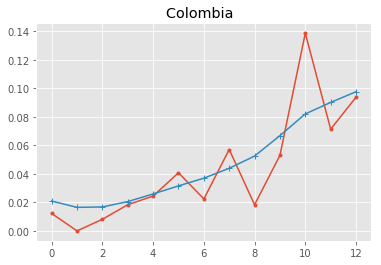

Peak not yet reached for Colombia  


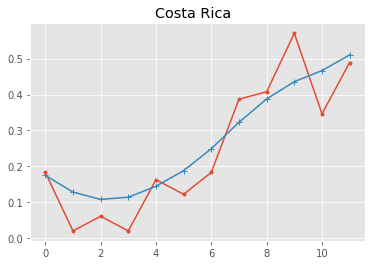

Peak not yet reached for Costa Rica  


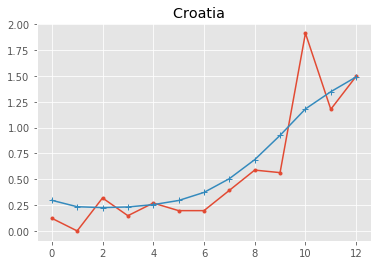

Peak not yet reached for Croatia  


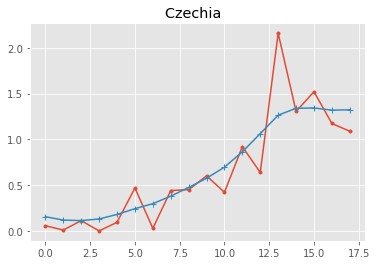

Peak not yet reached for Czechia  


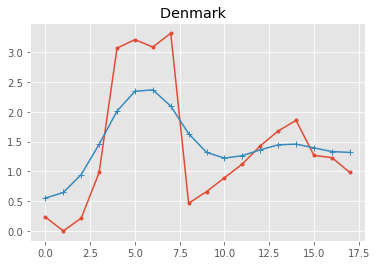

Peak reached for Denmark   in 6 days on 2020-03-12 00:00:00

Exponential fit parameters: a:0.5626 b:0.30
Covariance matrix of parameters:
[[ 0.00434949 -0.00177179]
 [-0.00177179  0.00080005]]


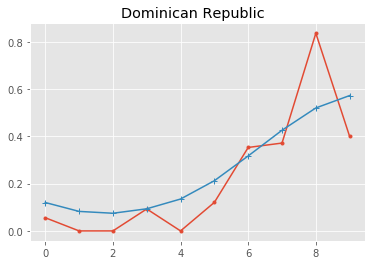

Peak not yet reached for Dominican Republic  


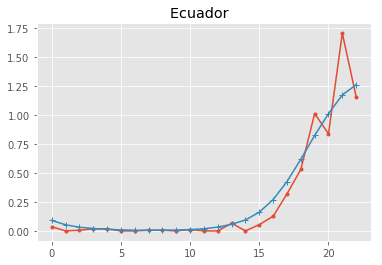

Peak not yet reached for Ecuador  


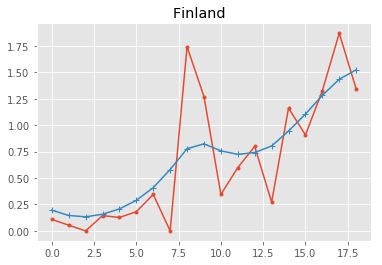

Peak not yet reached for Finland  


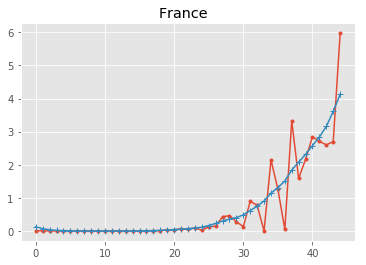

Peak not yet reached for France  


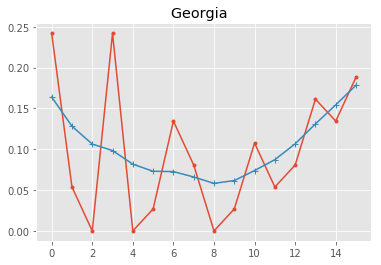

Peak not yet reached for Georgia  


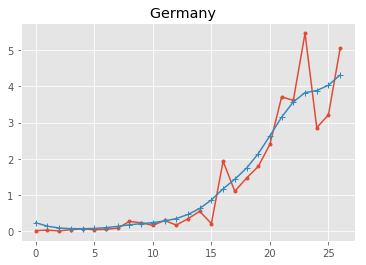

Peak not yet reached for Germany  


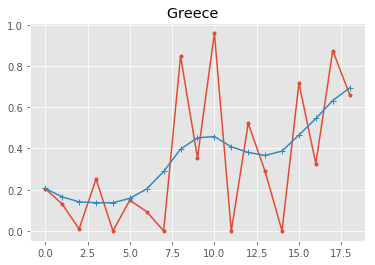

Peak not yet reached for Greece  


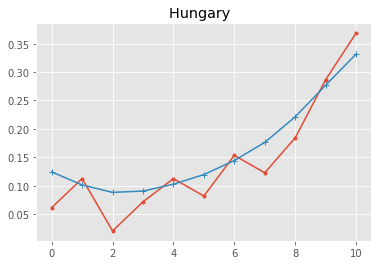

Peak not yet reached for Hungary  


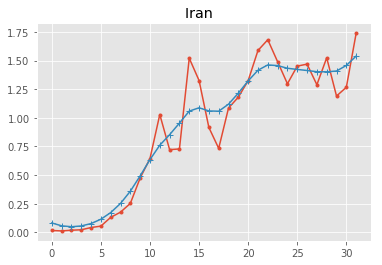

Peak not yet reached for Iran  


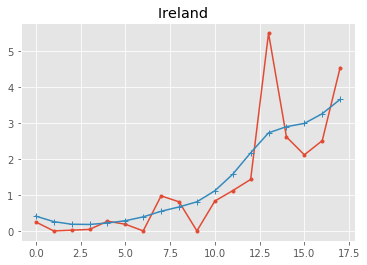

Peak not yet reached for Ireland  


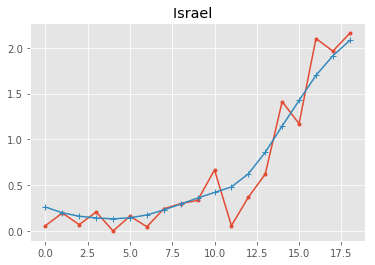

Peak not yet reached for Israel  


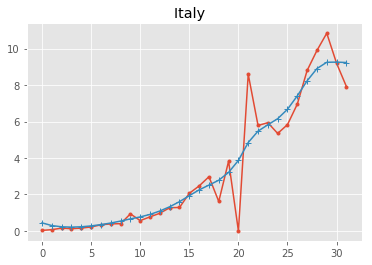

Peak not yet reached for Italy  


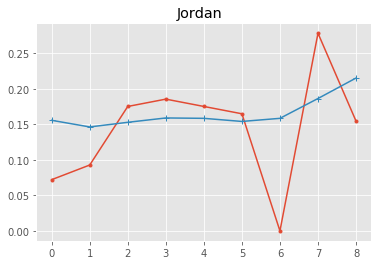

Peak not yet reached for Jordan  


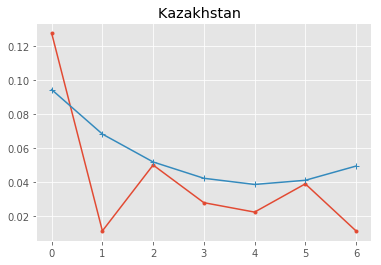

Peak not yet reached for Kazakhstan  


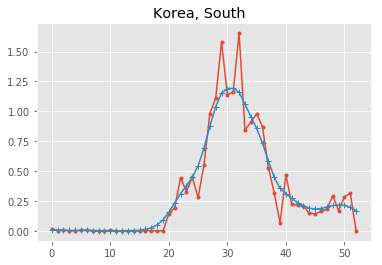

Peak reached for Korea, South   in 31 days on 2020-03-02 00:00:00

Exponential fit parameters: a:0.0042 b:0.19
Covariance matrix of parameters:
[[ 1.30918630e-06 -1.09814357e-05]
 [-1.09814357e-05  9.29028599e-05]]


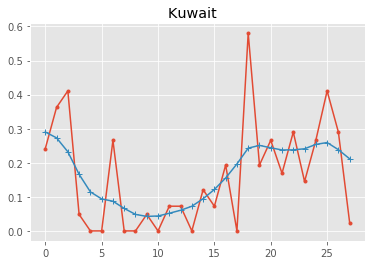

Peak not yet reached for Kuwait  


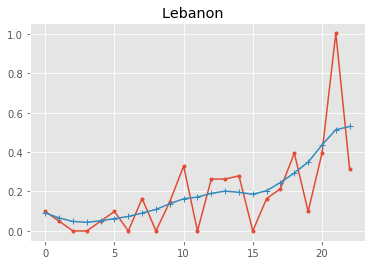

Peak not yet reached for Lebanon  


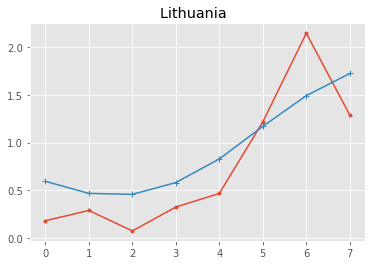

Peak not yet reached for Lithuania  


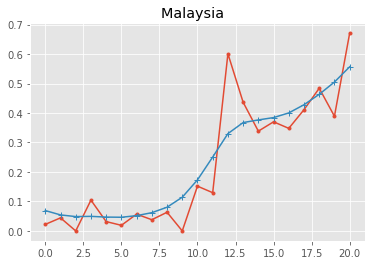

Peak not yet reached for Malaysia  


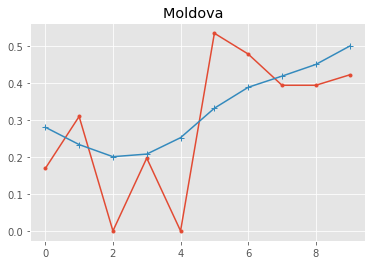

Peak not yet reached for Moldova  


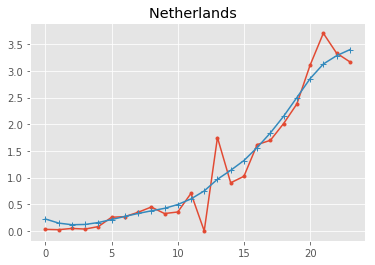

Peak not yet reached for Netherlands  


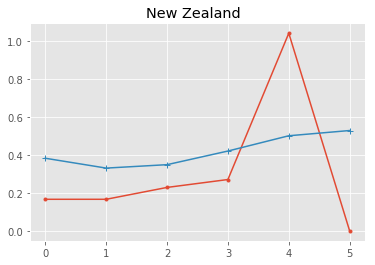

Peak not yet reached for New Zealand  


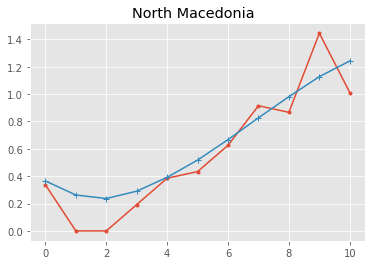

Peak not yet reached for North Macedonia  


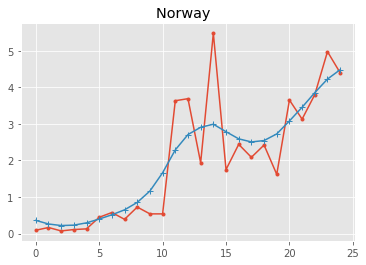

Peak not yet reached for Norway  


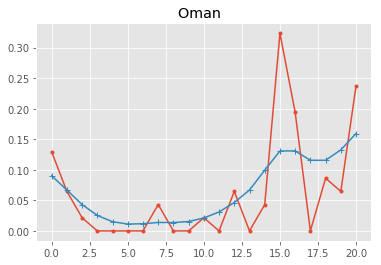

Peak not yet reached for Oman  


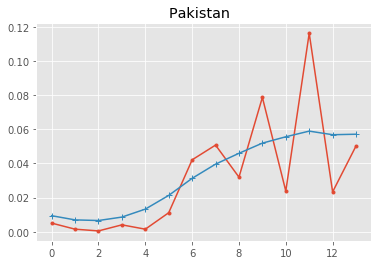

Peak not yet reached for Pakistan  


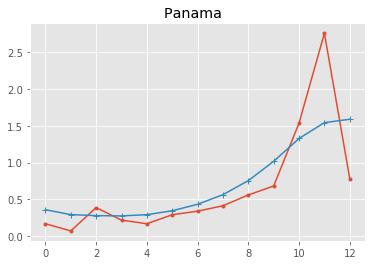

Peak not yet reached for Panama  


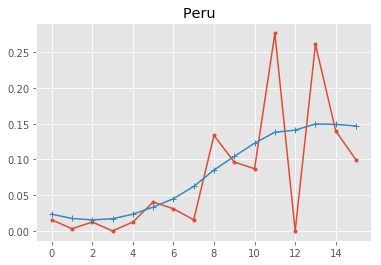

Peak not yet reached for Peru  


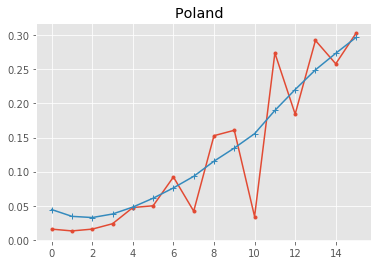

Peak not yet reached for Poland  


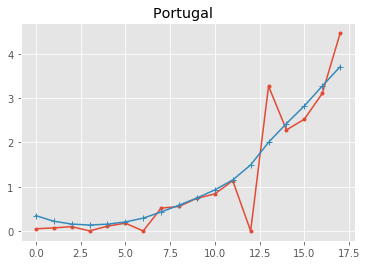

Peak not yet reached for Portugal  


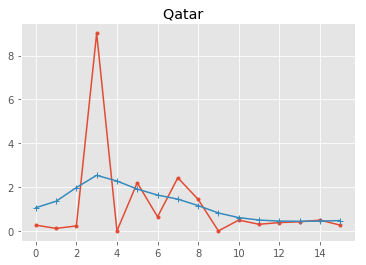

Peak not yet reached for Qatar  


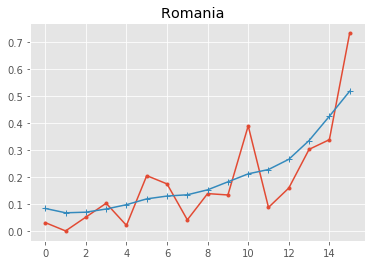

Peak not yet reached for Romania  


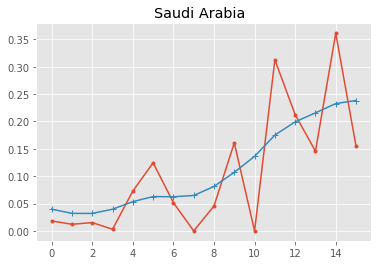

Peak not yet reached for Saudi Arabia  


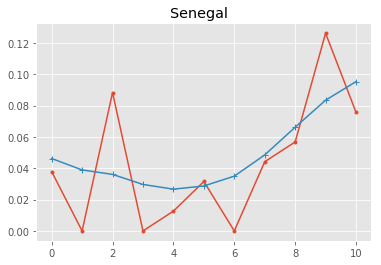

Peak not yet reached for Senegal  


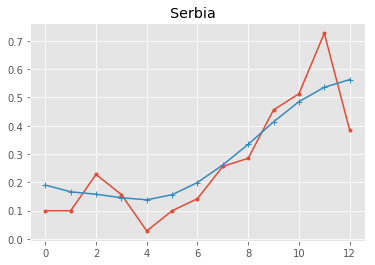

Peak not yet reached for Serbia  


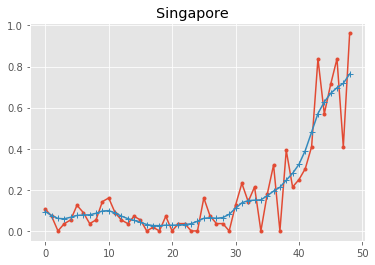

Peak not yet reached for Singapore  


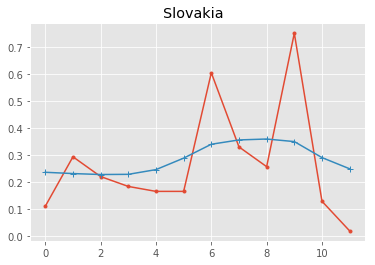

Peak not yet reached for Slovakia  


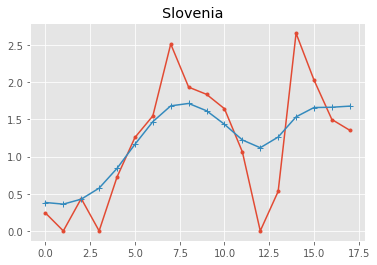

Peak reached for Slovenia   in 8 days on 2020-03-14 00:00:00

Exponential fit parameters: a:0.3095 b:0.25
Covariance matrix of parameters:
[[ 0.00111336 -0.00059115]
 [-0.00059115  0.00034103]]


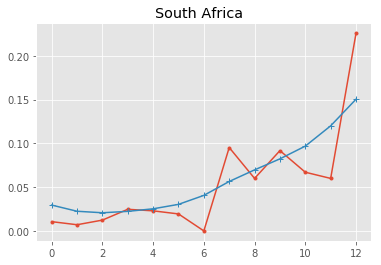

Peak not yet reached for South Africa  


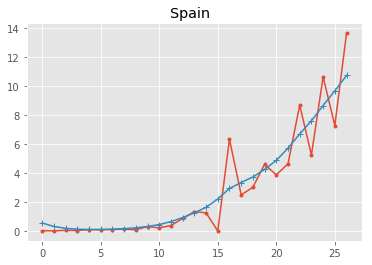

Peak not yet reached for Spain  


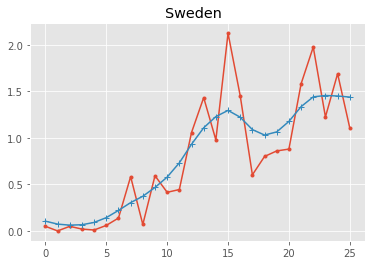

Peak not yet reached for Sweden  


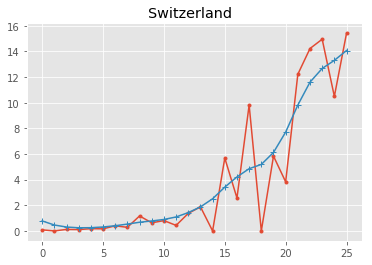

Peak not yet reached for Switzerland  


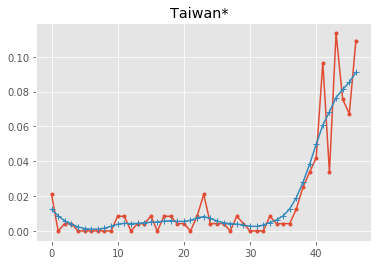

Peak not yet reached for Taiwan*  


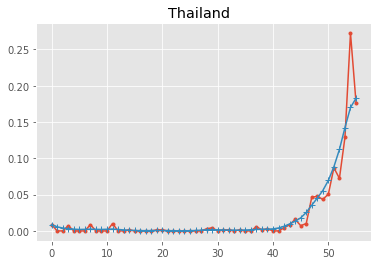

Peak not yet reached for Thailand  


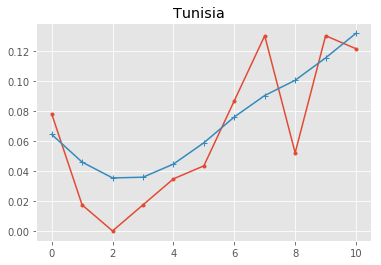

Peak not yet reached for Tunisia  


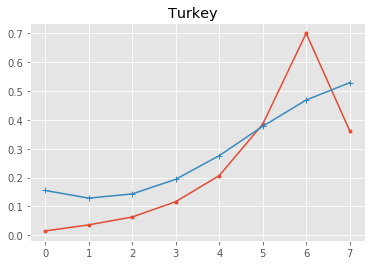

Peak not yet reached for Turkey  


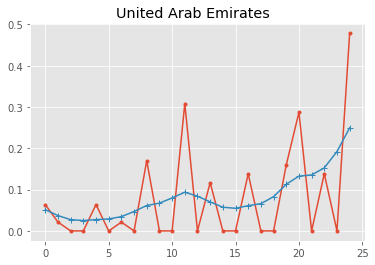

Peak not yet reached for United Arab Emirates  


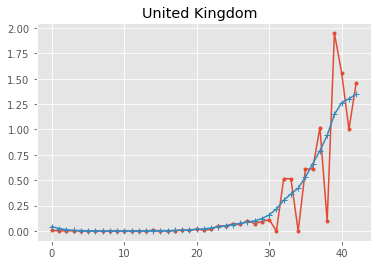

Peak not yet reached for United Kingdom  


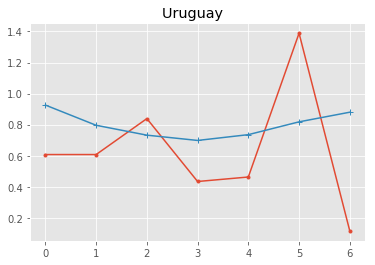

Peak not yet reached for Uruguay  


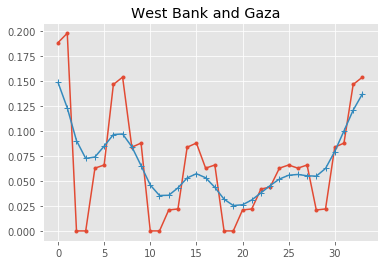

Peak not yet reached for West Bank and Gaza  


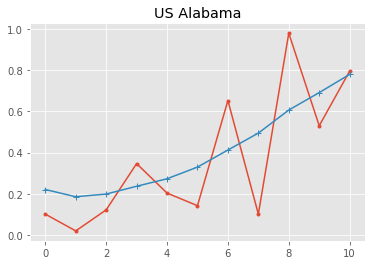

Peak not yet reached for US Alabama


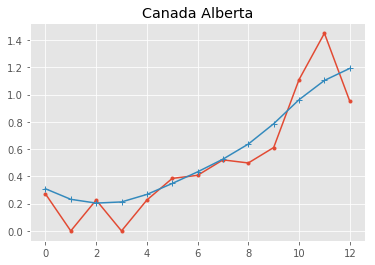

Peak not yet reached for Canada Alberta


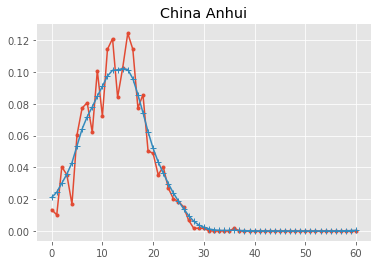

Peak reached for China Anhui in 14 days on 2020-02-06 00:00:00

Exponential fit parameters: a:0.0308 b:0.10
Covariance matrix of parameters:
[[ 8.53169347e-06 -2.61063520e-05]
 [-2.61063520e-05  9.00458190e-05]]


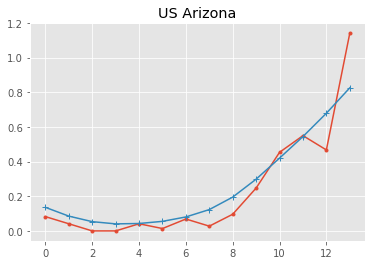

Peak not yet reached for US Arizona


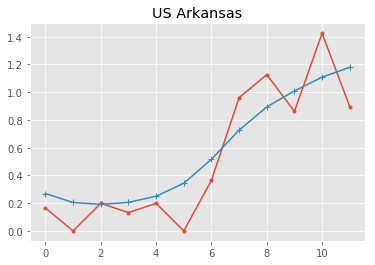

Peak not yet reached for US Arkansas


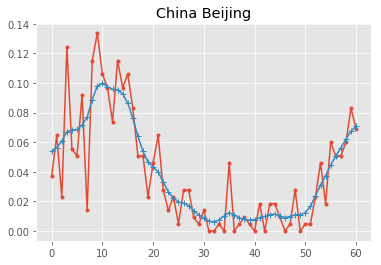

Peak reached for China Beijing in 10 days on 2020-02-02 00:00:00

Exponential fit parameters: a:0.0524 b:0.06
Covariance matrix of parameters:
[[ 3.55630167e-06 -9.83588246e-06]
 [-9.83588246e-06  3.40006811e-05]]


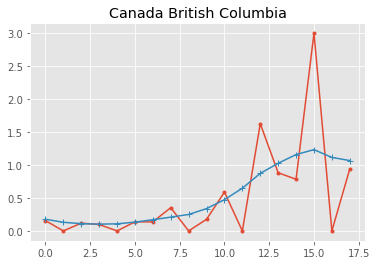

Peak not yet reached for Canada British Columbia


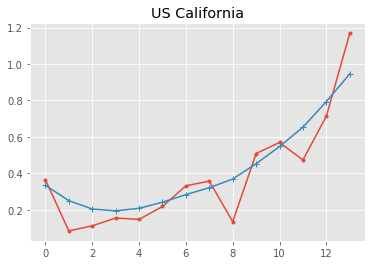

Peak not yet reached for US California


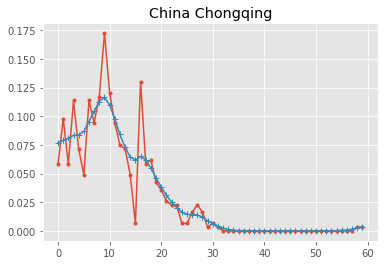

Peak reached for China Chongqing in 9 days on 2020-02-02 00:00:00

Exponential fit parameters: a:0.0726 b:0.05
Covariance matrix of parameters:
[[ 5.40786195e-06 -1.23521866e-05]
 [-1.23521866e-05  3.65870111e-05]]


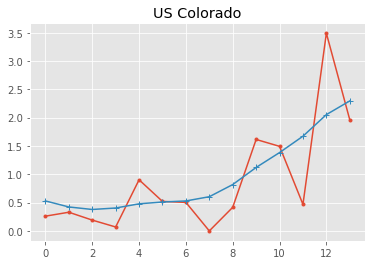

Peak not yet reached for US Colorado


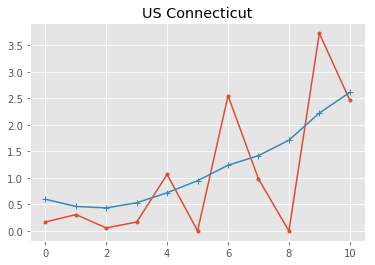

Peak not yet reached for US Connecticut


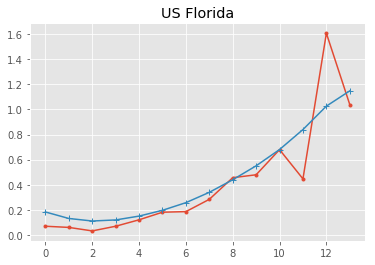

Peak not yet reached for US Florida


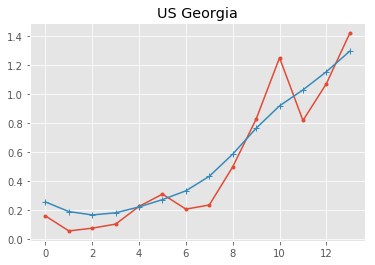

Peak not yet reached for US Georgia


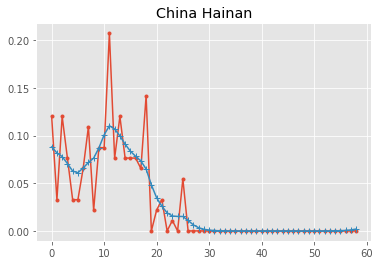

Peak reached for China Hainan in 11 days on 2020-02-05 00:00:00

Exponential fit parameters: a:0.0724 b:0.01
Covariance matrix of parameters:
[[ 4.65262172e-05 -9.00901366e-05]
 [-9.00901366e-05  2.38030723e-04]]


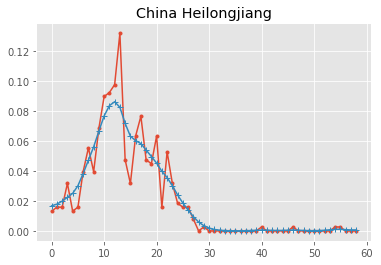

Peak reached for China Heilongjiang in 12 days on 2020-02-06 00:00:00

Exponential fit parameters: a:0.0147 b:0.16
Covariance matrix of parameters:
[[ 6.60659977e-07 -4.80017910e-06]
 [-4.80017910e-06  3.78396829e-05]]


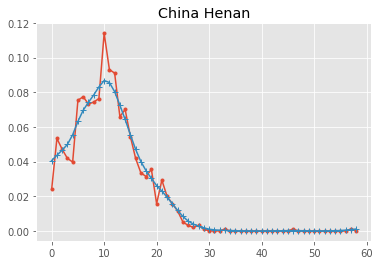

Peak reached for China Henan in 10 days on 2020-02-04 00:00:00

Exponential fit parameters: a:0.0404 b:0.08
Covariance matrix of parameters:
[[ 8.25549325e-07 -2.89626649e-06]
 [-2.89626649e-06  1.23291293e-05]]


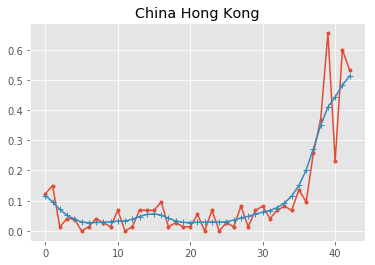

Peak not yet reached for China Hong Kong


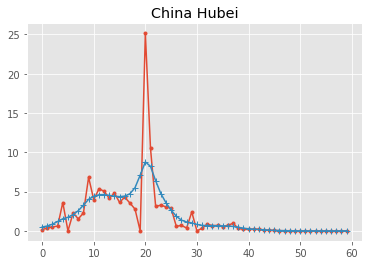

Peak reached for China Hubei in 20 days on 2020-02-13 00:00:00

Exponential fit parameters: a:1.4161 b:0.08
Covariance matrix of parameters:
[[ 4.37453900e-02 -1.97820286e-03]
 [-1.97820286e-03  9.89067208e-05]]


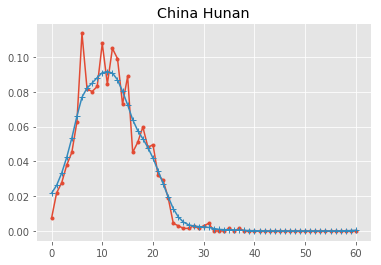

Peak reached for China Hunan in 11 days on 2020-02-03 00:00:00

Exponential fit parameters: a:0.0317 b:0.12
Covariance matrix of parameters:
[[ 1.42778286e-05 -5.52804077e-05]
 [-5.52804077e-05  2.45036047e-04]]


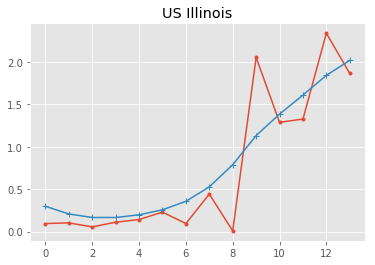

Peak not yet reached for US Illinois


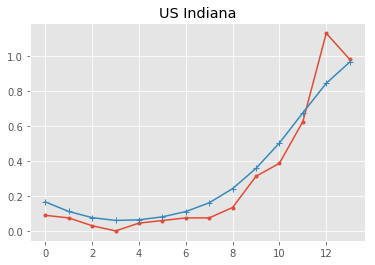

Peak not yet reached for US Indiana


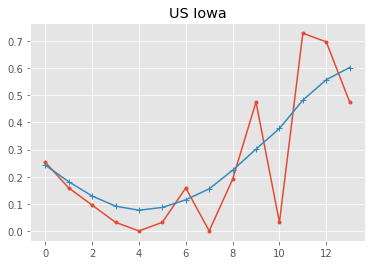

Peak not yet reached for US Iowa


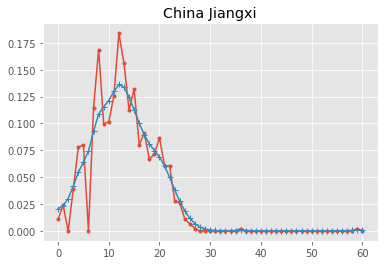

Peak reached for China Jiangxi in 12 days on 2020-02-04 00:00:00

Exponential fit parameters: a:0.0300 b:0.14
Covariance matrix of parameters:
[[ 1.15913345e-05 -4.18627588e-05]
 [-4.18627588e-05  1.66720759e-04]]


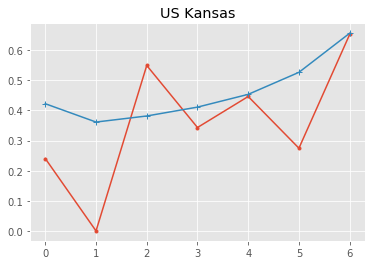

Peak not yet reached for US Kansas


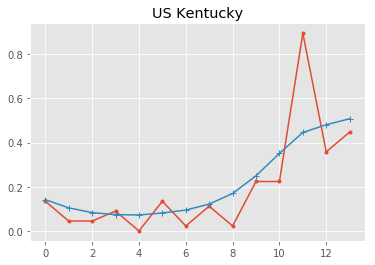

Peak not yet reached for US Kentucky


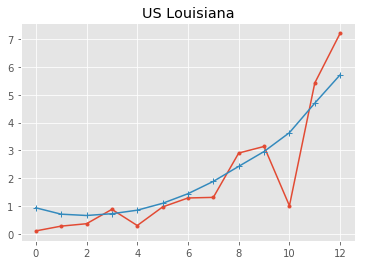

Peak not yet reached for US Louisiana


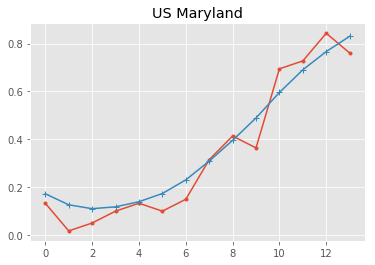

Peak not yet reached for US Maryland


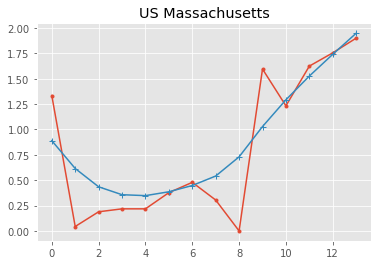

Peak not yet reached for US Massachusetts


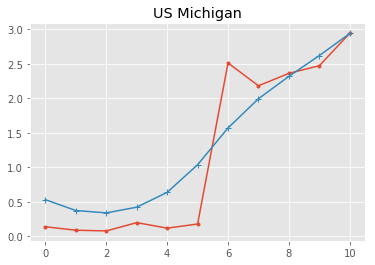

Peak not yet reached for US Michigan


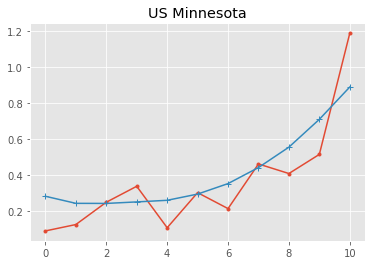

Peak not yet reached for US Minnesota


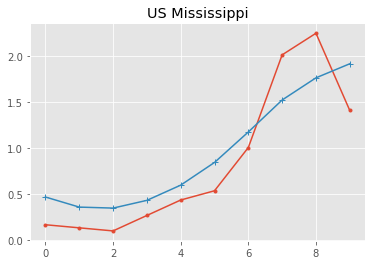

Peak not yet reached for US Mississippi


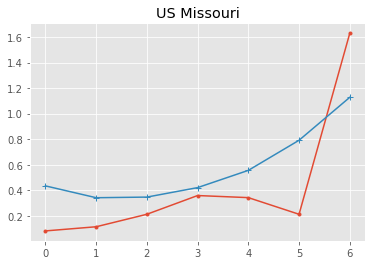

Peak not yet reached for US Missouri


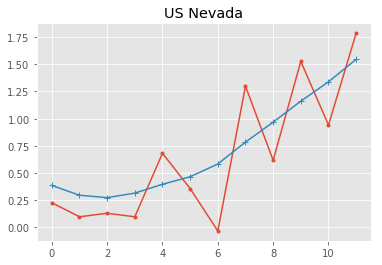

Peak not yet reached for US Nevada


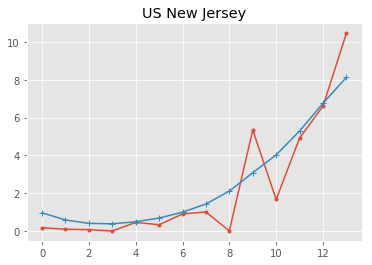

Peak not yet reached for US New Jersey


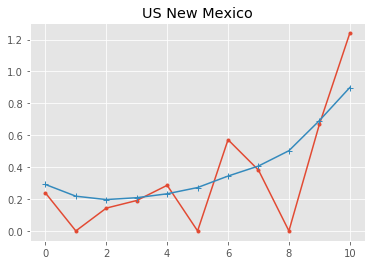

Peak not yet reached for US New Mexico


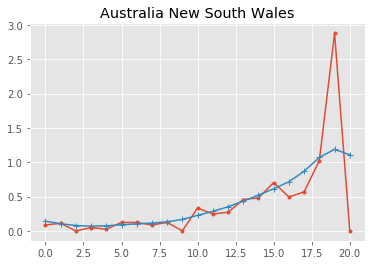

Peak not yet reached for Australia New South Wales


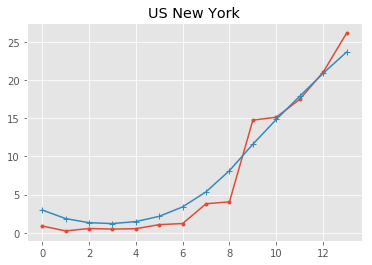

Peak not yet reached for US New York


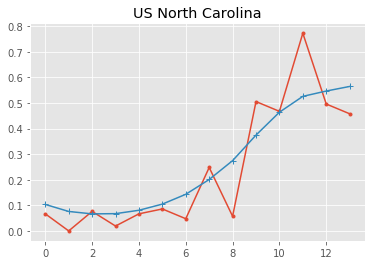

Peak not yet reached for US North Carolina


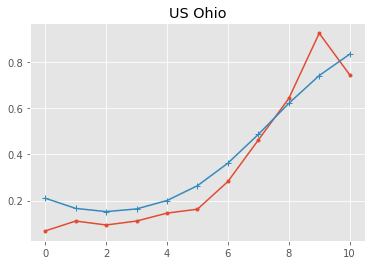

Peak not yet reached for US Ohio


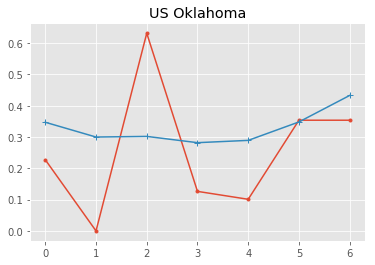

Peak not yet reached for US Oklahoma


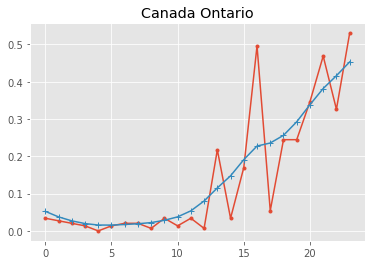

Peak not yet reached for Canada Ontario


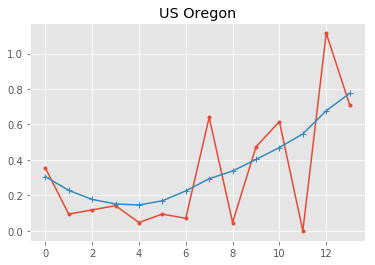

Peak not yet reached for US Oregon


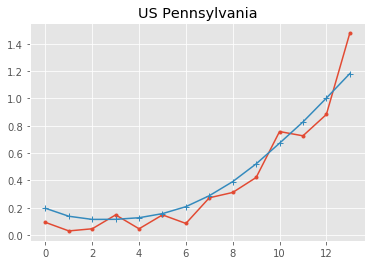

Peak not yet reached for US Pennsylvania


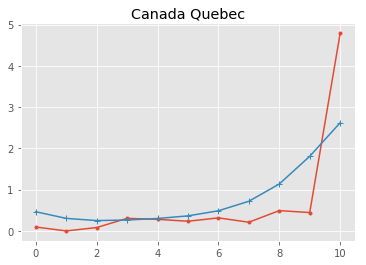

Peak not yet reached for Canada Quebec


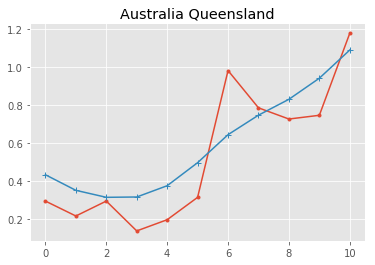

Peak not yet reached for Australia Queensland


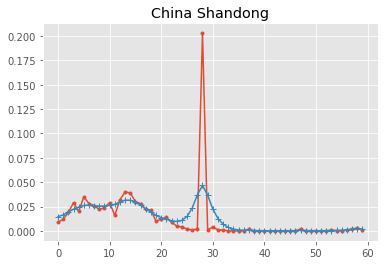

Peak reached for China Shandong in 28 days on 2020-02-21 00:00:00

Exponential fit parameters: a:0.0245 b:-0.01
Covariance matrix of parameters:
[[ 7.89965912e-06 -1.82781448e-05]
 [-1.82781448e-05  5.98012639e-05]]


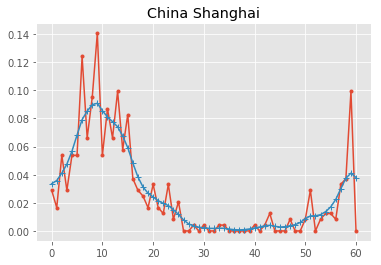

Peak reached for China Shanghai in 9 days on 2020-02-01 00:00:00

Exponential fit parameters: a:0.0335 b:0.13
Covariance matrix of parameters:
[[ 3.06534880e-06 -1.40306424e-05]
 [-1.40306424e-05  7.47683376e-05]]


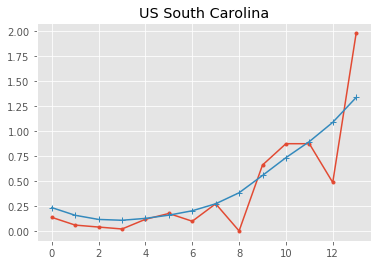

Peak not yet reached for US South Carolina


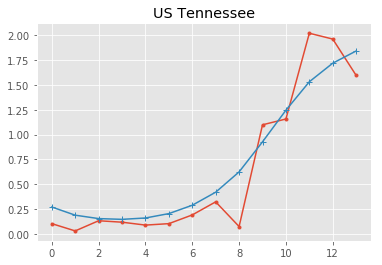

Peak not yet reached for US Tennessee


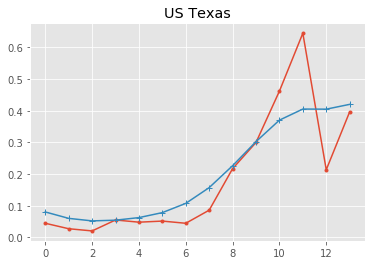

Peak not yet reached for US Texas


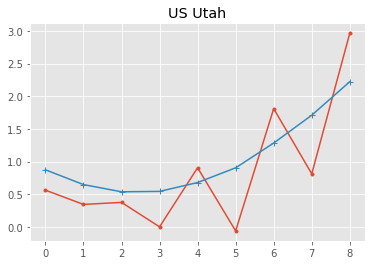

Peak not yet reached for US Utah


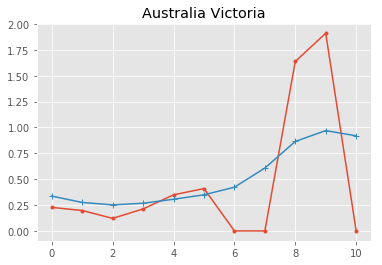

Peak not yet reached for Australia Victoria


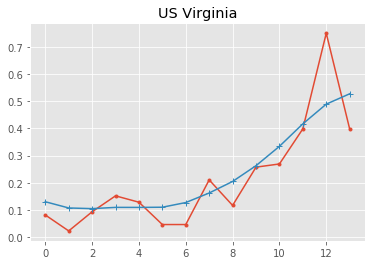

Peak not yet reached for US Virginia


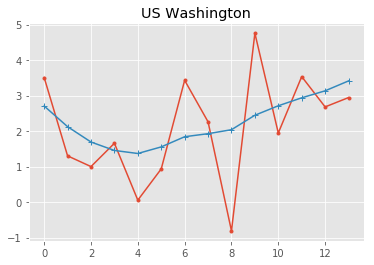

Peak not yet reached for US Washington


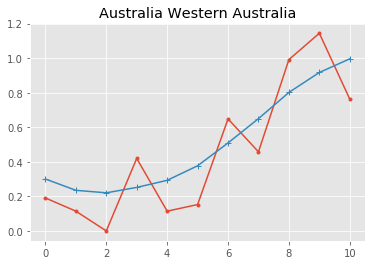

Peak not yet reached for Australia Western Australia


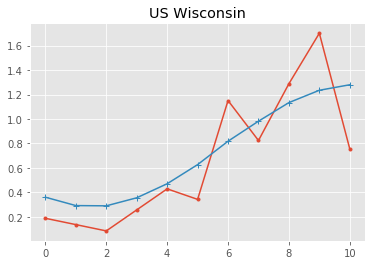

Peak not yet reached for US Wisconsin


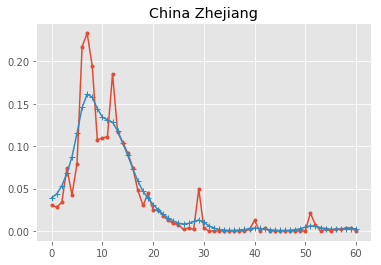

Peak reached for China Zhejiang in 7 days on 2020-01-30 00:00:00

Exponential fit parameters: a:0.0340 b:0.24
Covariance matrix of parameters:
[[ 1.81173748e-06 -1.03317195e-05]
 [-1.03317195e-05  6.55360739e-05]]


In [409]:

peak_duration = {}
param_list = []
for (ctry,prov) in ctry_prov_lst:
    fig, ax = plt.subplots()
    df_country = country_prov_select(ctry,prov,df_filt)
    plt.plot(df_country.new_cases_per_pop,marker='.')
    rbf=Rbf(df_country.index,df_country.new_cases_per_pop,smooth=5)(df_country.index)
    plt.plot(rbf,marker='+')
    ax.set_title(ctry+" "+prov)
    plt.show()
    peak_indx = np.argmax(rbf)
    peak_date = df_country.Date.iloc[peak_indx]
    #are we at least 5 days after peak of new cases and peak detection 5 days after start?
    peak_reached = (len(df_country) > peak_indx+4) & (peak_indx > 5)
    if peak_reached:
        print("Peak reached for {0} {1} in {2} days on {3}".format(ctry,prov,peak_indx,peak_date))
        peak_duration[(ctry,prov)]=peak_indx
        #exponential fit check
        params1, cov_params1 = curve_fit(exp_func,np.arange(peak_indx),rbf[:peak_indx],maxfev=10000,p0=[0.1,0.4])
        print("\nExponential fit parameters: a:{0:.4f} b:{1:.2f}".format(params1[0],params1[1]))
        print("Covariance matrix of parameters:")
        print(cov_params1)
        param_list.append(params1)
        #polynomial fit check
        #params2, cov_params2 = curve_fit(poly_func,np.arange(peak_indx),rbf[:peak_indx],maxfev=10000,p0=[0.01,0.5])
        #print("\nPolynomial fit parameters: a:{0:.4f} b:{1:.2f}".format(params2[0],params2[1]))
        #print("Covariance matrix of parameters:")
        #print(cov_params2)
        #sigmoid fit check
        #params3, cov_params3 = curve_fit(sigmoid_func,np.arange(peak_indx)+0.1,rbf[:peak_indx],maxfev=10000)
        #print("\nSigmoid fit parameters: a:{0:.2f} b:{1:.2f} c:{2:.2f}".format(params3[0],params3[1],params3[2]))
        #print("Covariance matrix of parameters:")
        #print(cov_params3) 
        #rough check for goodness of fit
        #if np.diag(cov_params1).sum() > np.diag(cov_params2).sum():
        #    print("\nPolynomial fit seems better.")
        #else:
        #    print("\nExponential fit seems better.")
    else:
        print("Peak not yet reached for {0} {1}".format(ctry,prov))

In [410]:
#df_filt[(df_filt['Country_Region']=='Kuwait') & (df_filt['Province_State']==' ')]

In [411]:
peak_duration

{('Denmark', ' '): 6,
 ('Korea, South', ' '): 31,
 ('Slovenia', ' '): 8,
 ('China', 'Anhui'): 14,
 ('China', 'Beijing'): 10,
 ('China', 'Chongqing'): 9,
 ('China', 'Hainan'): 11,
 ('China', 'Heilongjiang'): 12,
 ('China', 'Henan'): 10,
 ('China', 'Hubei'): 20,
 ('China', 'Hunan'): 11,
 ('China', 'Jiangxi'): 12,
 ('China', 'Shandong'): 28,
 ('China', 'Shanghai'): 9,
 ('China', 'Zhejiang'): 7}

In [412]:
peaked_countries = list(peak_duration.keys())

In [413]:
param_list #curve fitting result parameters

[array([0.56256027, 0.29534568]),
 array([0.00424163, 0.19235628]),
 array([0.30945084, 0.24887965]),
 array([0.03076632, 0.10148262]),
 array([0.05239276, 0.06357425]),
 array([0.07264419, 0.04919894]),
 array([0.07237717, 0.01147767]),
 array([0.01467544, 0.16250963]),
 array([0.04040974, 0.08323498]),
 array([1.41609724, 0.08088526]),
 array([0.03167009, 0.11758825]),
 array([0.02999334, 0.14237837]),
 array([ 0.0244601 , -0.00771944]),
 array([0.03352728, 0.13053324]),
 array([0.03399555, 0.2417887 ])]

In [414]:
avg_param = np.mean(param_list,axis=0)
avg_param

array([0.1819508 , 0.12756761])

In [415]:
#taking the 80% quantile as average since we have a bias from the first countries that recovered
avg_duration = round(np.quantile(list(peak_duration.values()),0.8))
avg_duration

15.0

In [416]:
max_duration = max(list(peak_duration.values()))
max_duration

31

In [417]:
#rough predict based on average/max duration to peak using exponential fitting parameters
FLAT = 5    #guess for number of days remaining at peak TBD optimize based on fitting to peaked countries
MAX_INC = 5 #arbitrary additional days prediction till peak for countries that lasted longer than history

def predict_new_cases(ctry,prov,df):
    df_country = country_prov_select(ctry,prov,df)
    pop_factor = int(df_pop[(df_pop['Country.Region']==ctry) & (df_pop['Province.State']==prov)].Population)/100000
    ctry_dates = df_country[['Date']].copy()
    ctry_confirmed = df_country[['ConfirmedCases']].copy()
    
    if len(df_country) > 1:
        rbf=Rbf(df_country.index,df_country.new_cases_per_pop,smooth=5)(df_country.index).clip(0)
    else:
        rbf=np.array(df_country.new_cases_per_pop).clip(0)
    peak_indx = np.argmax(rbf)
    peak_date = df_country.Date.iloc[peak_indx]
    #are we at least 5 days after peak of new cases and peak detection 5 days after start?
    peak_reached = (len(df_country) > peak_indx+4) & (peak_indx > 5)
    
    #exponential fitting TBD take parameters fitted from other peaked countries with similar characteristics
    if (peak_indx > 5) and (len(df_country) > 9):
        params, _ = curve_fit(exp_func,np.arange(peak_indx),rbf[:peak_indx],maxfev=10000,p0=[0.1,0.3])
    else:
        params = avg_param
    
    if peak_reached:
        print("Peak reached for {0} {1} in {2} days on {3}".format(ctry,prov,peak_indx,peak_date))
        dur = peak_indx
        if len(df_country) < dur*2+1+FLAT:
            #add predictions to decrease
            for j in range(len(df_country),dur*2+1+FLAT):
                pred = exp_func(2*dur-j+FLAT,params[0],params[1])
                rbf = np.append(rbf,pred)
                ctry_dates = ctry_dates.append(ctry_dates.iloc[-1]+timedelta(1))
                ctry_confirmed = ctry_confirmed.append(ctry_confirmed.iloc[-1]+pred*pop_factor)
    else:
        print("Peak not yet reached for {0} {1}".format(ctry,prov))
        #naive predict duration till new cases per day peak
        if len(df_country) < int(np.ceil(avg_duration)):
            dur = int(np.ceil(avg_duration))
        elif len(df_country) < max_duration:
            dur = max_duration
        else:
            dur = len(df_country)+MAX_INC
            print("Past due peaking for {0} {1}, arbitrary {2} days prediction".format(ctry,prov,MAX_INC))
        if (np.mean(df_country.NewCases[-5:])>5) and (df_country.ConfirmedCases.iloc[-1]>30):
            #add predictions till peak based on estimated function
            for j in range(len(df_country),dur+1):
                pred = exp_func(j,params[0],params[1])
                rbf = np.append(rbf, pred)
                ctry_dates = ctry_dates.append(ctry_dates.iloc[-1]+timedelta(1))
                ctry_confirmed = ctry_confirmed.append(ctry_confirmed.iloc[-1]+pred*pop_factor)
            #add predictions for remaining flat TBD curve fit to peaked countries
            rbf = np.append(rbf,np.ones(FLAT)*rbf[-1])
            for i in np.arange(FLAT):
                ctry_dates = ctry_dates.append(ctry_dates.iloc[-1]+timedelta(1))
                ctry_confirmed = ctry_confirmed.append(ctry_confirmed.iloc[-1]+pred*pop_factor)
            #add predictions to decrease
            for j in range(dur+FLAT,dur*2+1+FLAT):
                pred = exp_func(2*dur-j+FLAT,params[0],params[1])
                rbf = np.append(rbf,pred)
                ctry_dates = ctry_dates.append(ctry_dates.iloc[-1]+timedelta(1))
                ctry_confirmed = ctry_confirmed.append(ctry_confirmed.iloc[-1]+pred*pop_factor)
    
    while ctry_dates['Date'].iloc[-1] < PRED_LAST_DATE:
        rbf = np.append(rbf,np.mean(rbf[-3:]))
        ctry_dates = ctry_dates.append(ctry_dates.iloc[-1]+timedelta(1))
        ctry_confirmed = ctry_confirmed.append(ctry_confirmed.iloc[-1]+rbf[-1]*pop_factor)
    
    cases = rbf * pop_factor
    fig, ax = plt.subplots()
    plt.plot(np.arange(len(df_country)),cases[:len(df_country)],marker='+')
    plt.plot(np.arange(len(df_country),len(cases)),cases[len(df_country):],marker='.')
    ax.set_title(ctry+" "+prov+" predicted new daily cases")
    plt.show()
    print("Total predicted infected for {0} {1}: {2:d}\n".format(ctry,prov,int(ctry_confirmed.iloc[-1])))
    cases_df = pd.DataFrame(cases.astype(int),columns=['NewCases'])
    ctry_df = pd.DataFrame([ctry for i in range(len(cases))],columns=['Country/Region'])
    ctry_confirmed = ctry_confirmed.reset_index(drop=True).astype(int)
    return(pd.concat([ctry_df,ctry_dates.reset_index(drop=True),ctry_confirmed,cases_df],axis=1))

In [418]:
#country_prov_select('Indonesia',' ',df_corona_noexp)#.ConfirmedCases.iloc[-1]

Peak not yet reached for Czechia  
Past due peaking for Czechia  , arbitrary 5 days prediction


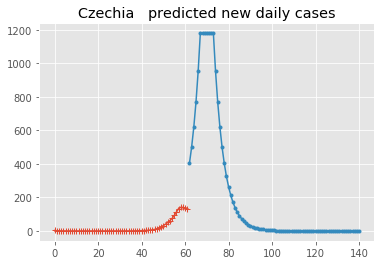

Total predicted infected for Czechia  : 17682



In [419]:
ctry = 'Czechia' #Belgium
prov = ' '
pred = predict_new_cases(ctry,prov,df_corona)

Peak not yet reached for Belgium  
Past due peaking for Belgium  , arbitrary 5 days prediction


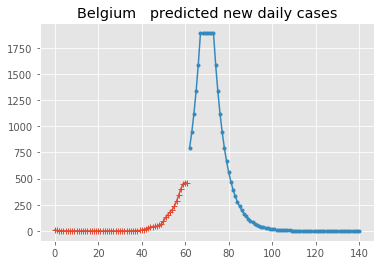

Total predicted infected for Belgium  : 32704



In [420]:
ctry = 'Belgium'
prov = ' '
pred = predict_new_cases(ctry,prov,df_corona)

In [421]:
df_last_day_train = train.groupby(['Country_Region','Province_State']).last().reset_index().copy()

In [422]:
sub.head()

ForecastId  ConfirmedCases  Fatalities
0           1               1           1
1           2               1           1
2           3               1           1
3           4               1           1
4           5               1           1

In [423]:
#loop over countries to initialize prediction with last known values
sub.set_index('ForecastId',inplace=True)
for i in df_last_day_train.index:
    pred = df_last_day_train.loc[i,'ConfirmedCases']
    ctry = df_last_day_train.loc[i,'Country_Region']
    prvn = df_last_day_train.loc[i,'Province_State']
    test_id = test[(test['Country_Region'] == ctry) & (test['Province_State'] == prvn)]['ForecastId']
    sub.loc[test_id,'ConfirmedCases']=pred
sub.reset_index(inplace=True)

In [424]:
#df_sub.reset_index(inplace=True)

Peak not yet reached for Albania  


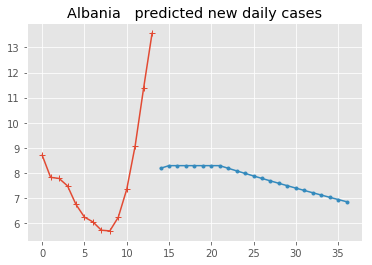

Total predicted infected for Albania  : 282



NameError: name 'df_sub' is not defined

In [425]:
#loop over countries in ctry_lst which we predict exponentially
for (ctry,prov) in ctry_prov_lst:
    #print(ctry,prov)
    pred = predict_new_cases(ctry,prov,df_filt)
    pred = pred[(pred['Date'] > TRAIN_LAST_DATE) & (pred['Date'] <= PRED_LAST_DATE)]
    test_id = test[(test['Country_Region'] == ctry) & 
                      (test['Province_State'] == prov) &
                      (test['Date'] > TRAIN_LAST_DATE)]['ForecastId']
    df_sub.loc[test_id,'ConfirmedCases']=pred['ConfirmedCases'].values
df_sub.reset_index(inplace=True)

In [426]:
#create df of countries not in exponential group and filter out all dates before there are at least 5 new daily cases
df_corona_noexp = pd.DataFrame(columns=df_corona.columns)
c = [c for (c,p) in ctry_prov_lst]
p = [p for (c,p) in ctry_prov_lst]
#countries that were not predicted by exponential fit
df_noexp = df_corona[~(df_corona['Country_Region'].isin(c)) | ~(df_corona['Province_State'].isin(p))]
for grp in df_noexp.groupby(['Province_State','Country_Region']):
    start_indx = grp[1].loc[grp[1].NewCases >= 5,:].index
    if len(start_indx) > 0:
        df_corona_noexp = pd.concat([df_corona_noexp,grp[1].loc[start_indx[0]:,:]])

In [427]:
df_corona_noexp.Country_Region.unique()

array(['Afghanistan', 'Andorra', 'Bahrain', 'Bangladesh', 'Barbados',
       'Bolivia', 'Brunei', 'Cameroon', 'Congo (Kinshasa)',
       "Cote d'Ivoire", 'Cuba', 'Cyprus', 'Diamond Princess', 'Egypt',
       'Estonia', 'Ghana', 'Guatemala', 'Guyana', 'Honduras', 'Iceland',
       'India', 'Indonesia', 'Iraq', 'Jamaica', 'Japan', 'Kenya',
       'Kyrgyzstan', 'Latvia', 'Liechtenstein', 'Luxembourg',
       'Madagascar', 'Malta', 'Mauritius', 'Mexico', 'Monaco',
       'Montenegro', 'Morocco', 'Nigeria', 'Paraguay', 'Philippines',
       'Russia', 'Rwanda', 'San Marino', 'Sri Lanka', 'Tanzania', 'Togo',
       'Trinidad and Tobago', 'Uganda', 'Ukraine', 'Uzbekistan',
       'Venezuela', 'Vietnam', 'US', 'Australia', 'United Kingdom',
       'Denmark', 'France', 'China', 'Canada'], dtype=object)

In [428]:
ctry_prov_noexp_lst = list(df_corona_noexp.set_index(['Country_Region','Province_State']).index.unique())

In [429]:
#df_sub.reset_index(inplace=True)

Afghanistan  
Peak not yet reached for Afghanistan  


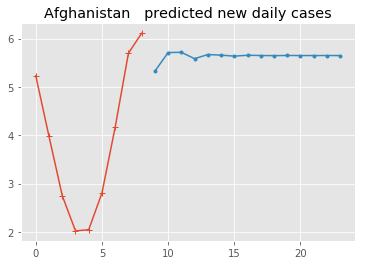

Total predicted infected for Afghanistan  : 124



NameError: name 'df_sub' is not defined

In [430]:
#loop over countries not in ctry_lst, smaller countries or those which did not yet start to get sick
#split loop only for convenient testing, could refactor to same loop above
for (ctry,prov) in ctry_prov_noexp_lst:
    print(ctry,prov)
    pred = predict_new_cases(ctry,prov,df_corona_noexp)
    pred = pred[(pred['Date'] > TRAIN_LAST_DATE) & (pred['Date'] <= PRED_LAST_DATE)]
    test_id = test[(test['Country_Region'] == ctry) & 
                      (test['Province_State'] == prov) &
                      (test['Date'] > TRAIN_LAST_DATE)]['ForecastId']
    df_sub.loc[test_id,'ConfirmedCases']=pred['ConfirmedCases'].values
df_sub.reset_index(inplace=True)

In [431]:
#country_prov_select('Canada','Newfoundland and Labrador',df_corona).tail(10)

In [432]:
sub['ConfirmedCases'] = sub['ConfirmedCases'].apply(lambda x: max(x,1))

In [433]:
#check fatality rate per country to prepare for prediction by country factors
fat = df_last_day_train.groupby('Country_Region')[['ConfirmedCases','Fatalities']].sum().reset_index()
fat['FatRate'] = fat['Fatalities']/ fat['ConfirmedCases']
fat.sort_values('FatRate',ascending=False)

Country_Region  ConfirmedCases  Fatalities   FatRate
155                  Sudan             2.0         1.0  0.500000
63                  Gambia             2.0         1.0  0.500000
179               Zimbabwe             3.0         1.0  0.333333
62                   Gabon             5.0         1.0  0.200000
142             San Marino           187.0        20.0  0.106952
..                     ...             ...         ...       ...
98                   Libya             0.0         0.0       NaN
102             MS Zaandam             0.0         0.0       NaN
106                   Mali             0.0         0.0       NaN
139  Saint Kitts and Nevis             0.0         0.0       NaN
147           Sierra Leone             0.0         0.0       NaN

[180 rows x 4 columns]

In [434]:
fat.describe()

ConfirmedCases   Fatalities     FatRate
count      180.000000   180.000000  169.000000
mean      2099.783333    91.655556    0.022438
std       9202.339445   559.477393    0.063660
min          0.000000     0.000000    0.000000
25%          4.000000     0.000000    0.000000
50%         78.000000     0.500000    0.002283
75%        411.000000     4.000000    0.017391
max      81498.000000  6077.000000    0.500000

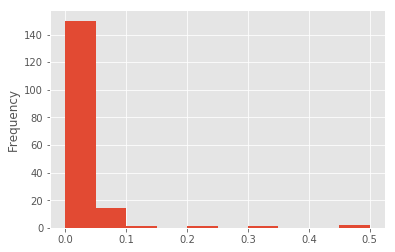

In [435]:
fat.FatRate.plot(kind='hist')

In [436]:
fatalities_avg = df_last_day_train.Fatalities.sum()/df_last_day_train.ConfirmedCases.sum()
fatalities_avg

0.043650006217572715

In [437]:
fatalities_ctry_mean = np.mean(df_last_day_train.Fatalities/df_last_day_train.ConfirmedCases)
fatalities_ctry_mean

0.018655679000679354

In [438]:
#country descriptive information from kaggle database
ctryinfo = pd.read_csv('/kaggle/input/countryinfo/covid19countryinfo.csv')

In [439]:
ctryinfo = ctryinfo.iloc[:193,:29]
ctryinfo = ctryinfo[ctryinfo.region.isnull()] #keep only main countries
ctryinfo

region              country alpha3code alpha2code         pop   tests  \
0      NaN          Afghanistan        AFG         AF  38,928,346     NaN   
1      NaN              Albania        ALB         AL   2,877,797     NaN   
2      NaN              Algeria        DZA         DZ  43,851,044     NaN   
3      NaN              Andorra        AND         AD      77,265     NaN   
4      NaN  Antigua and Barbuda        ATG         AG      97,929     NaN   
..     ...                  ...        ...        ...         ...     ...   
188    NaN           Uzbekistan        UZB         UZ  33,469,203     NaN   
189    NaN            Venezuela        VEN         VE  28,435,940     NaN   
190    NaN              Vietnam        VNM         VN  97,338,579  9696.0   
191    NaN               Zambia        ZMB         ZM  18,383,955     NaN   
192    NaN             Zimbabwe        ZWE         ZW  14,862,924     NaN   

         testpop  density  medianage  urbanpop  ... sex14 sex25 sex54  sex64  \
0            NaN     60.0       18.0      25.0  ...  1.03  1.03  1.03   0.97   
1            NaN    105.0       36.0      63.0  ...  1.11  1.09  0.93   0.95   
2            NaN     18.0       29.0      73.0  ...  1.05  1.05  1.03   1.01   
3            NaN    164.0       45.0      88.0  ...  1.05  1.08  1.05   1.15   
4            NaN    223.0       34.0      26.0  ...  1.03  0.99  0.84   0.82   
..           ...      ...        ...       ...  ...   ...   ...   ...    ...   
188          NaN     79.0       28.0      50.0  ...  1.05  1.03  0.99   0.90   
189          NaN     32.0       30.0      80.0  ...  1.05  1.03  0.98   0.92   
190  10039.04486    314.0       32.0      38.0  ...  1.11  1.08  1.01   0.85   
191          NaN     25.0       18.0      45.0  ...  1.01  1.00  1.02   0.88   
192          NaN     38.0       18.7      38.4  ...  1.02  1.02  1.10   0.58   

    sex65plus sexratio   lung  femalelung  malelung  gdp2019  
0        0.85     1.03  37.62       36.31     39.33   18,734  
1        0.87     0.98  11.67        7.02     17.04   15,418  
2        0.89     1.03   8.77        5.03     12.81  172,781  
3        1.02     1.06    NaN         NaN       NaN   91,527  
4        0.76     0.90  11.76        7.67     18.78    1,688  
..        ...      ...    ...         ...       ...      ...  
188      0.74     0.99  10.42        7.99     13.64   60,490  
189      0.79     0.99  22.34       18.58     27.11   70,140  
190      0.63     1.00  26.26       16.80     41.72  261,637  
191      0.76     1.00  20.04       15.20     26.16   23,946  
192      0.64     1.01  22.53       19.31     26.47   12,818  

[175 rows x 29 columns]

In [440]:
fat_pred = fat.merge(ctryinfo,left_on='Country_Region',
                     right_on='country',how='left',validate='1:1')
fat_pred = fat_pred[['Country_Region','FatRate','ConfirmedCases',
                     'density','medianage','urbanpop','hospibed',
                     'smokers', 'sexratio','lung',
                     'femalelung','malelung']].set_index('Country_Region').copy()

In [441]:
fat_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, Afghanistan to Zimbabwe
Data columns (total 11 columns):
FatRate           169 non-null float64
ConfirmedCases    180 non-null float64
density           172 non-null float64
medianage         172 non-null float64
urbanpop          172 non-null float64
hospibed          172 non-null float64
smokers           122 non-null float64
sexratio          169 non-null float64
lung              162 non-null float64
femalelung        162 non-null float64
malelung          162 non-null float64
dtypes: float64(11)
memory usage: 16.9+ KB


In [442]:
fat_pred

FatRate  ConfirmedCases  density  medianage  urbanpop  \
Country_Region                                                               
Afghanistan         0.025000            40.0     60.0       18.0      25.0   
Albania             0.038462           104.0    105.0       36.0      63.0   
Algeria             0.073913           230.0     18.0       29.0      73.0   
Andorra             0.007519           133.0    164.0       45.0      88.0   
Angola              0.000000             3.0      NaN        NaN       NaN   
...                      ...             ...      ...        ...       ...   
Venezuela           0.000000            77.0     32.0       30.0      80.0   
Vietnam             0.000000           123.0    314.0       32.0      38.0   
West Bank and Gaza  0.000000            59.0      NaN        NaN       NaN   
Zambia              0.000000             3.0     25.0       18.0      45.0   
Zimbabwe            0.333333             3.0     38.0       18.7      38.4   

                    hospibed  smokers  sexratio   lung  femalelung  malelung  
Country_Region                                                                
Afghanistan              0.5      NaN      1.03  37.62       36.31     39.33  
Albania                  2.9    29.40      0.98  11.67        7.02     17.04  
Algeria                  1.9      NaN      1.03   8.77        5.03     12.81  
Andorra                  2.5    32.50      1.06    NaN         NaN       NaN  
Angola                   NaN      NaN       NaN    NaN         NaN       NaN  
...                      ...      ...       ...    ...         ...       ...  
Venezuela                0.8      NaN      0.99  22.34       18.58     27.11  
Vietnam                  2.6    24.20      1.00  26.26       16.80     41.72  
West Bank and Gaza       NaN      NaN       NaN    NaN         NaN       NaN  
Zambia                   2.0    15.55      1.00  20.04       15.20     26.16  
Zimbabwe                 1.7    16.65      1.01  22.53       19.31     26.47  

[180 rows x 11 columns]

In [443]:
imput = SimpleImputer(strategy='median')
fat_nona = pd.DataFrame(imput.fit_transform(fat_pred),columns=fat_pred.columns, index=fat_pred.index)
fat_nona

FatRate  ConfirmedCases  density  medianage  urbanpop  \
Country_Region                                                               
Afghanistan         0.025000            40.0     60.0       18.0     25.00   
Albania             0.038462           104.0    105.0       36.0     63.00   
Algeria             0.073913           230.0     18.0       29.0     73.00   
Andorra             0.007519           133.0    164.0       45.0     88.00   
Angola              0.000000             3.0     89.0       32.0     63.15   
...                      ...             ...      ...        ...       ...   
Venezuela           0.000000            77.0     32.0       30.0     80.00   
Vietnam             0.000000           123.0    314.0       32.0     38.00   
West Bank and Gaza  0.000000            59.0     89.0       32.0     63.15   
Zambia              0.000000             3.0     25.0       18.0     45.00   
Zimbabwe            0.333333             3.0     38.0       18.7     38.40   

                    hospibed  smokers  sexratio   lung  femalelung  malelung  
Country_Region                                                                
Afghanistan              0.5    22.40      1.03  37.62       36.31    39.330  
Albania                  2.9    29.40      0.98  11.67        7.02    17.040  
Algeria                  1.9    22.40      1.03   8.77        5.03    12.810  
Andorra                  2.5    32.50      1.06  21.17       16.40    26.815  
Angola                   2.6    22.40      0.99  21.17       16.40    26.815  
...                      ...      ...       ...    ...         ...       ...  
Venezuela                0.8    22.40      0.99  22.34       18.58    27.110  
Vietnam                  2.6    24.20      1.00  26.26       16.80    41.720  
West Bank and Gaza       2.6    22.40      0.99  21.17       16.40    26.815  
Zambia                   2.0    15.55      1.00  20.04       15.20    26.160  
Zimbabwe                 1.7    16.65      1.01  22.53       19.31    26.470  

[180 rows x 11 columns]

In [444]:
fat_nona.corr()

FatRate  ConfirmedCases   density  medianage  urbanpop  \
FatRate         1.000000        0.083246 -0.030371  -0.131250 -0.043620   
ConfirmedCases  0.083246        1.000000 -0.021534   0.231795  0.118833   
density        -0.030371       -0.021534  1.000000   0.216434  0.173578   
medianage      -0.131250        0.231795  0.216434   1.000000  0.544164   
urbanpop       -0.043620        0.118833  0.173578   0.544164  1.000000   
hospibed       -0.082515        0.092653  0.303698   0.710069  0.357783   
smokers         0.004720        0.047803 -0.020819   0.381824  0.147919   
sexratio       -0.021962       -0.015420 -0.017034  -0.048539  0.140611   
lung            0.057124        0.084444 -0.033776  -0.261049 -0.313228   
femalelung      0.082350        0.108011 -0.031599  -0.290882 -0.314416   
malelung        0.021158        0.051234 -0.037056  -0.191607 -0.280458   

                hospibed   smokers  sexratio      lung  femalelung  malelung  
FatRate        -0.082515  0.004720 -0.021962  0.057124    0.082350  0.021158  
ConfirmedCases  0.092653  0.047803 -0.015420  0.084444    0.108011  0.051234  
density         0.303698 -0.020819 -0.017034 -0.033776   -0.031599 -0.037056  
medianage       0.710069  0.381824 -0.048539 -0.261049   -0.290882 -0.191607  
urbanpop        0.357783  0.147919  0.140611 -0.313228   -0.314416 -0.280458  
hospibed        1.000000  0.345931 -0.144549 -0.201873   -0.246324 -0.109282  
smokers         0.345931  1.000000 -0.049773 -0.028098   -0.087772  0.054072  
sexratio       -0.144549 -0.049773  1.000000 -0.063702   -0.044511 -0.103059  
lung           -0.201873 -0.028098 -0.063702  1.000000    0.964003  0.955171  
femalelung     -0.246324 -0.087772 -0.044511  0.964003    1.000000  0.846754  
malelung       -0.109282  0.054072 -0.103059  0.955171    0.846754  1.000000

In [445]:
x=fat_nona.iloc[:,1:]
y=fat_nona[['FatRate']]

In [446]:
#clf = RandomForestRegressor(max_depth=3)
#clf.fit(x,np.ravel(y))
clf = xgboost.XGBRegressor(objective='reg:squarederror')
clf.fit(x,y)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [447]:
pd.DataFrame(clf.feature_importances_,index=x.columns,columns=['Importance'])

Importance
ConfirmedCases    0.115836
density           0.216807
medianage         0.285803
urbanpop          0.058041
hospibed          0.027480
smokers           0.032327
sexratio          0.089029
lung              0.017962
femalelung        0.066989
malelung          0.089726

In [448]:
clf_preds = np.maximum(0,clf.predict(x))
mean_squared_log_error(clf_preds,y)

7.45059795963973e-07

In [449]:
fat['FatRate'] = clf_preds

In [450]:
fat

Country_Region  ConfirmedCases  Fatalities   FatRate
0           Afghanistan            40.0         1.0  0.024613
1               Albania           104.0         4.0  0.035312
2               Algeria           230.0        17.0  0.072424
3               Andorra           133.0         1.0  0.007252
4                Angola             3.0         0.0  0.000651
..                  ...             ...         ...       ...
175           Venezuela            77.0         0.0  0.002665
176             Vietnam           123.0         0.0  0.000666
177  West Bank and Gaza            59.0         0.0  0.002091
178              Zambia             3.0         0.0  0.001511
179            Zimbabwe             3.0         1.0  0.330867

[180 rows x 4 columns]

In [451]:
#loop over countries to set country specific fatality rates
sub.set_index('ForecastId',inplace=True)

for i in df_last_day_train.index:
    ctry = df_last_day_train.loc[i,'Country_Region']
    frate = fat.loc[fat['Country_Region']==ctry,'FatRate']
    prvn = df_last_day_train.loc[i,'Province_State']
    test_id = test[(test['Country_Region'] == ctry) & (test['Province_State'] == prvn) ]['ForecastId']
    sub.loc[test_id,'Fatalities']=round(sub.loc[test_id,'ConfirmedCases']*frate.values)
#sub.reset_index(inplace=True)

In [452]:
#placeholder for calculating fatalities factor per country/cluster
sub['Fatalities'] = round(sub['ConfirmedCases']*fatalities_avg)

In [453]:
sub.describe()

ConfirmedCases    Fatalities
count    13158.000000  13158.000000
mean      1235.218954     53.892157
std       6261.996558    273.314626
min          1.000000      0.000000
25%         13.000000      1.000000
50%         98.000000      4.000000
75%        402.000000     18.000000
max      67800.000000   2959.000000

In [454]:
score

Province_State Country_Region       Date  ConfirmedCases_act  \
15                         Albania 2020-03-24               123.0   
16                         Albania 2020-03-25               146.0   
17                         Albania 2020-03-26               174.0   
18                         Albania 2020-03-27               186.0   
19                         Albania 2020-03-28               197.0   
...             ...            ...        ...                 ...   
4576                      Zimbabwe 2020-03-25                 3.0   
4577                      Zimbabwe 2020-03-26                 3.0   
4578                      Zimbabwe 2020-03-27                 5.0   
4579                      Zimbabwe 2020-03-28                 7.0   
4580                      Zimbabwe 2020-03-29                 7.0   

      Fatalities_act  NewCases  NewFatalities  ForecastId  \
15               5.0      19.0            1.0        63.0   
16               5.0      23.0            0.0        64.0   
17               6.0      28.0            1.0        65.0   
18               8.0      12.0            2.0        66.0   
19              10.0      11.0            2.0        67.0   
...              ...       ...            ...         ...   
4576             1.0       0.0            0.0     13154.0   
4577             1.0       0.0            0.0     13155.0   
4578             1.0       2.0            0.0     13156.0   
4579             1.0       2.0            0.0     13157.0   
4580             1.0       0.0            0.0     13158.0   

      ConfirmedCases_pred  Fatalities_pred  ConfirmedCasesError  \
15                  104.0              5.0             0.027663   
16                  104.0              5.0             0.113214   
17                  104.0              5.0             0.260943   
18                  104.0              5.0             0.333100   
19                  104.0              5.0             0.402345   
...                   ...              ...                  ...   
4576                  3.0              0.0             0.000000   
4577                  3.0              0.0             0.000000   
4578                  3.0              0.0             0.164402   
4579                  3.0              0.0             0.480453   
4580                  3.0              0.0             0.480453   

      FatalitiesError  
15           0.000000  
16           0.000000  
17           0.023762  
18           0.164402  
19           0.367401  
...               ...  
4576         0.480453  
4577         0.480453  
4578         0.480453  
4579         0.480453  
4580         0.480453  

[2556 rows x 12 columns]

In [455]:
score = df_eval.merge(sub, on=['ForecastId'], right_index=True, 
                      #validate='1:1',
                      suffixes=('_act','_pred'))
score['ConfirmedCasesError']=(np.log1p(score['ConfirmedCases_act'])-np.log1p(score['ConfirmedCases_pred']))**2
score['FatalitiesError']=(np.log1p(score['Fatalities_act'])-np.log1p(score['Fatalities_pred']))**2
score_c = np.sqrt(mean_squared_log_error(score['ConfirmedCases_act'], score['ConfirmedCases_pred']))
score_f = np.sqrt(mean_squared_log_error(score['Fatalities_act'], score['Fatalities_pred']))
print("Confirmed score: {0:.2f}, Fatalities score:{1:.2f}, Mean: {2:.2f}".format(score_c,score_f,np.mean([score_c, score_f])))

Confirmed score: 1.21, Fatalities score:1.01, Mean: 1.11


In [456]:
score.describe()

ConfirmedCases_act  Fatalities_act     NewCases  NewFatalities  \
count         2556.000000     2556.000000  2556.000000    2556.000000   
mean          2220.932316       88.584507   169.260955       7.804382   
std           8828.103788      610.336991   569.950411      42.833963   
min              0.000000        0.000000   -15.000000      -3.000000   
25%             35.750000        0.000000     0.000000       0.000000   
50%            212.000000        3.000000    11.000000       0.000000   
75%            955.000000       16.000000    87.250000       2.000000   
max         139875.000000    17127.000000  8060.000000     791.000000   

         ForecastId  ConfirmedCases_pred  Fatalities_pred  \
count   2556.000000          2556.000000      2556.000000   
mean    6591.943662          1013.387324        44.218701   
std     3788.402778          5720.773815       249.671450   
min       63.000000             1.000000         0.000000   
25%     3305.750000            13.000000         1.000000   
50%     6610.500000           104.000000         5.000000   
75%     9853.250000           395.000000        17.000000   
max    13158.000000         67800.000000      2959.000000   

       ConfirmedCasesError  FatalitiesError  
count          2556.000000      2556.000000  
mean              1.460383         1.010142  
std               2.037364         1.460031  
min               0.000000         0.000000  
25%               0.115822         0.000000  
50%               0.697224         0.480453  
75%               2.055824         1.417695  
max              19.789298         9.269117

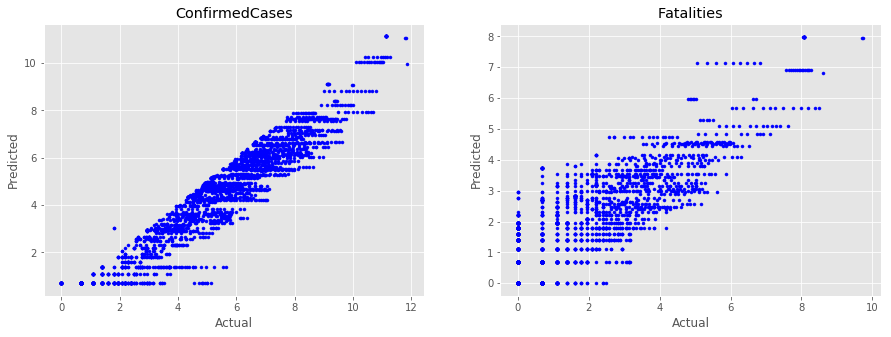

In [457]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(x = np.log1p(score['ConfirmedCases_act']),
            y= np.log1p(score['ConfirmedCases_pred'])
            ,marker='.',color='b')
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.title("ConfirmedCases")
plt.subplot(1,2,2,)
plt.scatter(x = np.log1p(score['Fatalities_act']), y= np.log1p(score['Fatalities_pred']), marker='.',color='b')
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.title("Fatalities")
plt.show()